<a href="https://colab.research.google.com/github/Rysekk/MNIST-100labels/blob/main/Deep_Learning_projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist

from random import randint
#Import de la base de donnée MNIST

(train_X, train_y), (test_X, test_y) = mnist.load_data()

print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [2]:
import numpy as np

#creation des matrices pour stocker les 100 labels
train_X100label = np.zeros(shape=(100,28,28)).astype('uint8')
train_y100label = np.zeros(shape=(100)).astype('uint8')

#On selectionne dans X_train et Y_train les 100 labels 
counter = 0
for i in range(10):
    train_filter = np.where(train_y == [i])
    for j in range(10):
        X_train, Y_train = train_X[train_filter], train_y[train_filter]
        
        train_X100label[counter] = X_train[counter]
        train_y100label[counter] = Y_train[counter]
        counter+=1

label num 0:  0


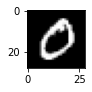

label num 1:  1


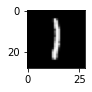

label num 2:  2


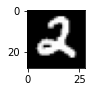

label num 3:  3


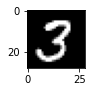

label num 4:  4


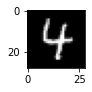

label num 5:  5


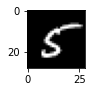

label num 6:  6


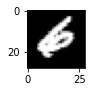

label num 7:  7


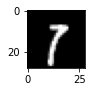

label num 8:  8


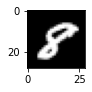

label num 9:  9


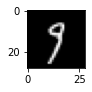

In [3]:
#plot chaque dizaine des 100 labels selectionés
from matplotlib import pyplot
for i in range(10):
    pyplot.subplot(2,5,1+i)
    pyplot.imshow(train_X100label[i*10], cmap=pyplot.get_cmap('gray'))
    print("label num "+str(i)+": ",train_y100label[i*10])
    pyplot.show()

In [4]:
#suppression des veleur qui ne servent plus
del X_train,Y_train,train_X,train_y,train_filter,i,j,counter

In [5]:
#Il ne reste plus qu'à les melanger pour avoir un truc non-uniforme et sans biais
# Using zip() + * operator + shuffle()
import random
temp = list(zip(train_y100label, train_X100label))
random.shuffle(temp)
train_y100label, train_X100label = zip(*temp)

y_train = np.array(train_y100label).astype('uint8')
x_train = np.array(train_X100label).astype('uint8')

### Data Processing

In [6]:
#pour le test
import tensorflow as tf
#on ajoute un canneau 
x_test = test_X.reshape((10000,28,28,1))
#pour le rgb (donc = 3)
x_test = x_test.repeat(3,-1)
#on normalise
x_test = x_test.astype('float32')/255
#on reshape l'image pour quelle corresponde a l'input du resnet50 qui doit etre du 32 x 32 
x_test = tf.image.resize(x_test,[32,32])
#on convertie le train en tensor
x_test = tf.convert_to_tensor(x_test)

In [7]:
#pour le train
x_train = x_train.reshape((100,28,28,1))
x_train = x_train.repeat(3,-1)
x_train = x_train.astype('float32')/255
x_train = tf.image.resize(x_train,[32,32])
x_train = tf.convert_to_tensor(x_train)

In [8]:
#pour les y on les transformes en one hot encoder
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(test_y)
y_train = to_categorical(y_train)

In [9]:
#implementation resnet50
import os
import sys 
import datetime
import tensorboard
import numpy as np
import tensorflow as tf
import tensorboard
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential,Model
from keras.layers import Dense, Conv2D, Flatten,LeakyReLU,Dropout,Activation,Reshape,Conv2DTranspose,Input,Lambda
from keras.datasets import mnist
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import gc
from keras import backend 
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import numpy as np

In [10]:
# custom activation function 
def custom_activation(output):
	logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
	result = logexpsum / (logexpsum + 1.0)
	return result

In [11]:
# define the standalone supervised and unsupervised discriminator models
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# image input
	in_image = Input(shape=in_shape)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(in_image)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output layer nodes
	fe = Dense(n_classes)(fe)
	# supervised output
	c_out_layer = Activation('softmax')(fe)
	# define and compile supervised discriminator model
	c_model = Model(in_image, c_out_layer)
	c_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
	# unsupervised output
	d_out_layer = Lambda(custom_activation)(fe)
	# define and compile unsupervised discriminator model
	d_model = Model(in_image, d_out_layer)
	d_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
	return d_model, c_model
d_model, c_model = define_discriminator()

"""
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# image input
    sup_discriminateur = Sequential()

	# downsample
    sup_discriminateur.add(Conv2D(128, (3,3), strides=(2,2), padding='same',input_shape=in_shape))
    sup_discriminateur.add(LeakyReLU(alpha=0.2))

	# downsample
    sup_discriminateur.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    sup_discriminateur.add(LeakyReLU(alpha=0.2))

	# flatten feature maps
    sup_discriminateur.add(Flatten())

	# dropout
    sup_discriminateur.add(Dropout(0.4))

	# output layer nodes / supervised output
    sup_discriminateur.add(Dense(n_classes))
    sup_discriminateur.add(Activation('softmax'))
	# compile supervised discriminator model
    sup_discriminateur.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

    #------------------------------------------------------------------------------------------------------------------------------------------------------------------
    #unsupervised generator
    
    # image input
    un_discriminateur = Sequential()

	# downsample
    un_discriminateur.add(Conv2D(128, (3,3), strides=(2,2), padding='same',input_shape=in_shape))
    un_discriminateur.add(LeakyReLU(alpha=0.2))

	# downsample
    un_discriminateur.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    un_discriminateur.add(LeakyReLU(alpha=0.2))

	# flatten feature maps
    un_discriminateur.add(Flatten())

	# dropout
    un_discriminateur.add(Dropout(0.4))

	# output layer nodes / supervised output
    un_discriminateur.add(Dense(n_classes))
    un_discriminateur.add(Activation(custom_activation, name='SpecialActivation'))
	# compile supervised discriminator model
    un_discriminateur.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

	# define and compile unsupervised discriminator model
    un_discriminateur.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return un_discriminateur, sup_discriminateur
 
# create model
un_discriminateur, sup_discriminateur = define_discriminator()
"""

"\ndef define_discriminator(in_shape=(28,28,1), n_classes=10):\n\t# image input\n    sup_discriminateur = Sequential()\n\n\t# downsample\n    sup_discriminateur.add(Conv2D(128, (3,3), strides=(2,2), padding='same',input_shape=in_shape))\n    sup_discriminateur.add(LeakyReLU(alpha=0.2))\n\n\t# downsample\n    sup_discriminateur.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))\n    sup_discriminateur.add(LeakyReLU(alpha=0.2))\n\n\t# flatten feature maps\n    sup_discriminateur.add(Flatten())\n\n\t# dropout\n    sup_discriminateur.add(Dropout(0.4))\n\n\t# output layer nodes / supervised output\n    sup_discriminateur.add(Dense(n_classes))\n    sup_discriminateur.add(Activation('softmax'))\n\t# compile supervised discriminator model\n    sup_discriminateur.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])\n\n    #-------------------------------------------------------------------------------------------------------

In [12]:
# plot the model
plot_model(d_model, to_file='stacked_discriminator1_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [13]:
plot_model(c_model, to_file='stacked_discriminator2_plot.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [14]:
# define the standalone generator model
def define_generator(latent_dim):
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model(in_lat, out_layer)
	return model

plot_model(define_generator(100), to_file='generator.png', show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [15]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect image output from generator as input to discriminator
	gan_output = d_model(g_model.output)
	# define gan model as taking noise and outputting a classification
	model = Model(g_model.input, gan_output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [16]:
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = mnist.load_data()
	# expand to 3d, e.g. add channels
	X = np.expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	print(X.shape, trainy.shape)
	return [X, trainy]

In [17]:
# select a supervised subset of the dataset, ensures classes are balanced
def select_supervised_samples(dataset, n_samples=100, n_classes=10):
	X, y = dataset
	X_list, y_list = list(), list()
	n_per_class = int(n_samples / n_classes)
	for i in range(n_classes):
		# get all images for this class
		X_with_class = X[y == i]
		# choose random instances
		ix = np.random.randint(0, len(X_with_class), n_per_class)
		# add to list
		[X_list.append(X_with_class[j]) for j in ix]
		[y_list.append(i) for j in ix]
	return np.asarray(X_list), np.asarray(y_list)

In [18]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = np.random.randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [19]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	z_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = z_input.reshape(n_samples, latent_dim)
	return z_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict(z_input)
	# create class labels
	y = np.zeros((n_samples, 1))
	return images, y

In [20]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, c_model, latent_dim, dataset, n_samples=100):
	# prepare fake examples
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	# plot images
	for i in range(100):
		# define subplot
		pyplot.subplot(10, 10, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename1 = 'generated_plot_%04d.png' % (step+1)
	pyplot.savefig(filename1)
	pyplot.close()
	# evaluate the classifier model
	X, y = dataset
	_, acc = c_model.evaluate(X, y, verbose=0)
	print('Classifier Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'g_model_%04d.h5' % (step+1)
	g_model.save(filename2)
	# save the classifier model
	filename3 = 'c_model_%04d.h5' % (step+1)
	c_model.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))

In [21]:
# train the generator and discriminator
import random
def train(g_model, d_model, c_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):
	# select supervised dataset
	X_sup, y_sup = select_supervised_samples(dataset)
	print(X_sup.shape, y_sup.shape)
    
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
    
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
    
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, half_batch, bat_per_epo, n_steps))
	# manually enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (c)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		c_loss, c_acc = c_model.train_on_batch(Xsup_real, ysup_real)
        
		# update unsupervised discriminator (d)
		[X_real, _], y_real = generate_real_samples(dataset, half_batch)
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
        
		# update generator (g)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(X_gan, y_gan)
        
		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, c_loss, c_acc*100, d_loss1, d_loss2, g_loss))
        
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, g_model, c_model, latent_dim, dataset)

In [22]:
# size of the latent space
latent_dim = 100
# create the discriminator models
d_model, c_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, c_model, gan_model, dataset, latent_dim)

(60000, 28, 28, 1) (60000,)
(100, 28, 28, 1) (100,)
n_epochs=20, n_batch=100, 1/2=50, b/e=600, steps=12000
>1, c[2.293,12], d[0.095,2.399], g[0.095]
>2, c[2.300,12], d[0.090,2.398], g[0.095]
>3, c[2.304,6], d[0.086,2.399], g[0.095]
>4, c[2.273,22], d[0.081,2.402], g[0.095]
>5, c[2.286,12], d[0.078,2.406], g[0.095]
>6, c[2.239,22], d[0.076,2.407], g[0.095]
>7, c[2.284,22], d[0.076,2.401], g[0.096]
>8, c[2.233,24], d[0.077,2.390], g[0.098]
>9, c[2.229,22], d[0.079,2.374], g[0.099]
>10, c[2.241,22], d[0.079,2.366], g[0.100]
>11, c[2.103,34], d[0.080,2.362], g[0.100]
>12, c[2.092,24], d[0.074,2.369], g[0.099]
>13, c[2.095,26], d[0.066,2.385], g[0.098]
>14, c[2.097,30], d[0.058,2.392], g[0.098]
>15, c[2.032,28], d[0.048,2.372], g[0.102]
>16, c[2.120,28], d[0.039,2.325], g[0.108]
>17, c[1.972,36], d[0.034,2.286], g[0.112]
>18, c[2.024,30], d[0.025,2.263], g[0.115]
>19, c[1.972,38], d[0.021,2.256], g[0.116]
>20, c[1.900,42], d[0.016,2.250], g[0.119]
>21, c[1.735,52], d[0.015,2.229], g[0.129]


>188, c[0.229,96], d[0.829,0.863], g[1.104]
>189, c[0.135,100], d[0.746,0.953], g[1.006]
>190, c[0.120,98], d[0.861,0.809], g[1.228]
>191, c[0.162,96], d[0.771,1.259], g[1.379]
>192, c[0.169,98], d[0.931,0.822], g[1.160]
>193, c[0.096,100], d[0.707,1.000], g[1.197]
>194, c[0.160,100], d[0.836,0.968], g[1.189]
>195, c[0.103,100], d[0.846,0.882], g[1.200]
>196, c[0.121,98], d[0.657,0.993], g[1.494]
>197, c[0.130,100], d[0.833,0.925], g[1.397]
>198, c[0.085,100], d[1.071,0.740], g[1.176]
>199, c[0.131,98], d[0.885,0.923], g[1.126]
>200, c[0.127,98], d[0.839,1.015], g[1.250]
>201, c[0.110,100], d[0.780,0.721], g[1.180]
>202, c[0.189,94], d[0.829,0.917], g[1.336]
>203, c[0.118,98], d[0.988,0.835], g[1.331]
>204, c[0.092,98], d[0.934,0.835], g[1.246]
>205, c[0.124,100], d[0.795,1.003], g[1.222]
>206, c[0.151,98], d[0.710,0.893], g[1.304]
>207, c[0.116,98], d[0.828,0.802], g[1.133]
>208, c[0.114,100], d[0.812,0.772], g[1.221]
>209, c[0.213,96], d[0.591,1.044], g[1.247]
>210, c[0.138,100], d[0

>372, c[0.049,100], d[0.822,0.678], g[1.315]
>373, c[0.071,100], d[0.547,0.813], g[1.563]
>374, c[0.042,100], d[0.752,0.742], g[1.496]
>375, c[0.069,98], d[0.852,0.679], g[1.461]
>376, c[0.044,100], d[0.978,0.664], g[1.255]
>377, c[0.055,100], d[0.536,0.704], g[1.303]
>378, c[0.056,100], d[0.858,0.648], g[0.998]
>379, c[0.029,100], d[0.931,0.966], g[1.145]
>380, c[0.042,100], d[0.771,0.794], g[1.423]
>381, c[0.042,100], d[0.877,0.702], g[1.343]
>382, c[0.035,100], d[0.708,0.815], g[1.111]
>383, c[0.056,100], d[0.759,0.959], g[1.011]
>384, c[0.044,98], d[0.682,1.106], g[1.208]
>385, c[0.055,100], d[0.767,0.763], g[1.351]
>386, c[0.039,100], d[1.108,0.947], g[1.217]
>387, c[0.028,100], d[0.736,0.989], g[1.285]
>388, c[0.083,98], d[1.017,0.952], g[1.223]
>389, c[0.044,100], d[0.651,0.863], g[1.232]
>390, c[0.044,100], d[0.938,1.077], g[1.397]
>391, c[0.042,100], d[0.944,0.862], g[1.210]
>392, c[0.037,100], d[0.802,0.897], g[1.281]
>393, c[0.077,100], d[0.985,0.935], g[1.072]
>394, c[0.046

>555, c[0.038,100], d[0.595,0.806], g[1.359]
>556, c[0.029,100], d[1.044,0.965], g[1.319]
>557, c[0.036,100], d[0.679,0.491], g[1.241]
>558, c[0.017,100], d[0.827,0.845], g[1.096]
>559, c[0.032,100], d[0.754,1.150], g[1.223]
>560, c[0.028,100], d[0.721,0.664], g[1.259]
>561, c[0.027,100], d[0.875,0.718], g[1.287]
>562, c[0.022,100], d[1.161,0.799], g[1.090]
>563, c[0.051,98], d[0.577,0.781], g[1.222]
>564, c[0.020,100], d[0.808,0.728], g[1.245]
>565, c[0.020,100], d[0.645,0.647], g[1.196]
>566, c[0.034,100], d[0.602,0.772], g[1.338]
>567, c[0.024,100], d[0.890,0.710], g[1.301]
>568, c[0.022,100], d[0.954,0.845], g[1.149]
>569, c[0.032,100], d[0.924,0.954], g[1.271]
>570, c[0.031,100], d[0.613,0.640], g[1.393]
>571, c[0.018,100], d[0.768,0.679], g[1.417]
>572, c[0.036,100], d[0.930,1.001], g[1.224]
>573, c[0.022,100], d[0.734,0.675], g[1.047]
>574, c[0.037,100], d[0.650,1.200], g[1.150]
>575, c[0.025,100], d[0.897,0.611], g[1.301]
>576, c[0.041,100], d[0.740,0.746], g[1.252]
>577, c[0.0

>733, c[0.021,100], d[0.763,0.815], g[1.285]
>734, c[0.038,100], d[0.655,0.921], g[1.497]
>735, c[0.037,100], d[0.725,0.891], g[1.364]
>736, c[0.031,100], d[0.633,0.894], g[1.372]
>737, c[0.042,100], d[0.752,0.814], g[1.150]
>738, c[0.019,100], d[0.799,0.648], g[1.161]
>739, c[0.031,100], d[0.522,0.743], g[1.364]
>740, c[0.029,100], d[0.682,0.490], g[1.206]
>741, c[0.042,100], d[0.808,0.811], g[1.299]
>742, c[0.021,100], d[0.687,0.746], g[1.278]
>743, c[0.033,100], d[0.669,0.748], g[1.216]
>744, c[0.051,98], d[0.735,0.722], g[1.238]
>745, c[0.027,100], d[0.729,0.672], g[1.037]
>746, c[0.023,100], d[0.756,0.875], g[1.208]
>747, c[0.021,100], d[0.591,0.800], g[1.260]
>748, c[0.011,100], d[0.758,0.658], g[1.348]
>749, c[0.027,100], d[0.850,0.844], g[1.213]
>750, c[0.036,100], d[0.743,0.828], g[1.199]
>751, c[0.023,100], d[0.590,0.697], g[1.224]
>752, c[0.014,100], d[0.661,0.877], g[1.208]
>753, c[0.028,100], d[0.890,0.764], g[1.102]
>754, c[0.023,100], d[0.547,0.715], g[1.290]
>755, c[0.0

>916, c[0.011,100], d[0.600,0.699], g[1.372]
>917, c[0.032,100], d[0.724,0.594], g[1.375]
>918, c[0.020,100], d[0.798,0.703], g[1.334]
>919, c[0.015,100], d[0.745,0.777], g[1.029]
>920, c[0.014,100], d[0.830,0.890], g[1.199]
>921, c[0.025,100], d[0.698,0.703], g[1.175]
>922, c[0.029,100], d[0.772,0.886], g[1.373]
>923, c[0.046,98], d[0.674,0.830], g[1.262]
>924, c[0.018,100], d[0.649,0.738], g[1.387]
>925, c[0.019,100], d[0.789,0.662], g[1.266]
>926, c[0.013,100], d[0.749,0.813], g[1.099]
>927, c[0.012,100], d[0.791,0.863], g[1.292]
>928, c[0.011,100], d[0.821,0.813], g[1.343]
>929, c[0.034,100], d[0.587,0.730], g[1.413]
>930, c[0.015,100], d[0.700,0.582], g[1.141]
>931, c[0.019,100], d[0.634,0.614], g[1.316]
>932, c[0.020,100], d[0.697,0.678], g[1.061]
>933, c[0.042,100], d[0.606,0.724], g[1.322]
>934, c[0.028,100], d[0.573,0.546], g[1.335]
>935, c[0.009,100], d[0.812,0.860], g[1.267]
>936, c[0.021,100], d[0.768,0.716], g[1.259]
>937, c[0.012,100], d[0.642,0.630], g[1.274]
>938, c[0.0

>1097, c[0.010,100], d[0.584,0.673], g[1.157]
>1098, c[0.019,100], d[0.779,0.818], g[1.071]
>1099, c[0.011,100], d[0.757,0.822], g[1.106]
>1100, c[0.010,100], d[0.795,0.588], g[1.079]
>1101, c[0.016,100], d[0.598,0.707], g[1.091]
>1102, c[0.010,100], d[0.601,1.121], g[1.198]
>1103, c[0.036,100], d[0.765,0.706], g[1.313]
>1104, c[0.016,100], d[0.718,0.695], g[1.210]
>1105, c[0.009,100], d[0.773,0.712], g[1.327]
>1106, c[0.018,100], d[0.713,0.737], g[1.195]
>1107, c[0.017,100], d[0.620,0.759], g[1.496]
>1108, c[0.016,100], d[0.608,0.718], g[1.389]
>1109, c[0.010,100], d[0.963,0.793], g[1.239]
>1110, c[0.016,100], d[0.652,0.676], g[1.176]
>1111, c[0.013,100], d[0.670,0.642], g[1.344]
>1112, c[0.013,100], d[0.520,0.615], g[1.320]
>1113, c[0.017,100], d[0.775,0.876], g[1.331]
>1114, c[0.022,100], d[0.669,0.834], g[1.218]
>1115, c[0.014,100], d[0.835,0.553], g[1.256]
>1116, c[0.009,100], d[0.769,0.691], g[1.197]
>1117, c[0.016,100], d[0.574,0.788], g[1.245]
>1118, c[0.021,100], d[0.678,0.590

>1270, c[0.013,100], d[0.951,0.828], g[1.169]
>1271, c[0.010,100], d[0.638,0.498], g[1.095]
>1272, c[0.017,100], d[0.700,0.766], g[1.241]
>1273, c[0.021,100], d[0.847,0.716], g[1.185]
>1274, c[0.011,100], d[0.488,0.607], g[1.293]
>1275, c[0.017,100], d[1.049,0.715], g[1.321]
>1276, c[0.009,100], d[0.799,0.743], g[1.121]
>1277, c[0.013,100], d[0.675,0.622], g[1.121]
>1278, c[0.014,100], d[0.627,0.797], g[1.245]
>1279, c[0.015,100], d[0.549,0.656], g[1.236]
>1280, c[0.011,100], d[0.717,0.771], g[1.378]
>1281, c[0.006,100], d[0.922,0.598], g[1.072]
>1282, c[0.007,100], d[0.750,0.780], g[0.979]
>1283, c[0.014,100], d[0.606,0.701], g[1.348]
>1284, c[0.011,100], d[0.852,0.607], g[1.214]
>1285, c[0.009,100], d[0.782,0.916], g[1.314]
>1286, c[0.009,100], d[0.697,0.781], g[1.316]
>1287, c[0.011,100], d[0.634,0.642], g[1.203]
>1288, c[0.007,100], d[0.827,0.622], g[1.110]
>1289, c[0.017,100], d[0.445,0.948], g[1.323]
>1290, c[0.006,100], d[0.627,0.619], g[1.202]
>1291, c[0.011,100], d[0.817,0.856

>1449, c[0.009,100], d[0.588,0.656], g[1.369]
>1450, c[0.013,100], d[0.638,0.840], g[1.564]
>1451, c[0.007,100], d[0.560,0.519], g[1.368]
>1452, c[0.017,100], d[0.852,0.667], g[1.336]
>1453, c[0.014,100], d[0.781,0.669], g[1.158]
>1454, c[0.009,100], d[0.638,0.811], g[1.316]
>1455, c[0.008,100], d[0.727,0.860], g[1.205]
>1456, c[0.006,100], d[0.475,0.781], g[1.198]
>1457, c[0.010,100], d[0.809,0.590], g[1.196]
>1458, c[0.014,100], d[0.786,0.773], g[1.375]
>1459, c[0.016,100], d[0.994,0.794], g[1.253]
>1460, c[0.008,100], d[0.652,0.543], g[1.120]
>1461, c[0.015,100], d[0.647,1.059], g[1.247]
>1462, c[0.012,100], d[0.712,0.797], g[1.368]
>1463, c[0.010,100], d[0.801,0.492], g[1.190]
>1464, c[0.016,100], d[0.828,0.672], g[1.163]
>1465, c[0.010,100], d[0.573,0.806], g[1.211]
>1466, c[0.007,100], d[0.803,0.915], g[1.347]
>1467, c[0.007,100], d[0.676,0.612], g[1.382]
>1468, c[0.012,100], d[0.887,0.803], g[1.168]
>1469, c[0.019,100], d[0.754,0.911], g[1.317]
>1470, c[0.008,100], d[0.797,0.795

>1629, c[0.009,100], d[0.844,0.711], g[1.262]
>1630, c[0.004,100], d[0.579,0.622], g[1.129]
>1631, c[0.010,100], d[0.871,0.602], g[1.114]
>1632, c[0.009,100], d[0.839,0.843], g[1.083]
>1633, c[0.009,100], d[0.570,0.580], g[1.065]
>1634, c[0.008,100], d[0.696,0.760], g[1.095]
>1635, c[0.006,100], d[0.459,0.741], g[1.251]
>1636, c[0.011,100], d[0.543,0.855], g[1.219]
>1637, c[0.005,100], d[0.800,0.763], g[1.329]
>1638, c[0.007,100], d[0.687,0.810], g[1.191]
>1639, c[0.006,100], d[0.453,0.680], g[1.357]
>1640, c[0.014,100], d[0.536,0.566], g[1.466]
>1641, c[0.006,100], d[0.938,0.719], g[1.398]
>1642, c[0.004,100], d[0.839,0.754], g[1.147]
>1643, c[0.007,100], d[0.905,0.926], g[1.300]
>1644, c[0.015,100], d[0.608,0.797], g[1.267]
>1645, c[0.008,100], d[0.945,0.810], g[1.109]
>1646, c[0.012,100], d[0.696,0.603], g[1.127]
>1647, c[0.015,100], d[0.728,0.940], g[1.340]
>1648, c[0.009,100], d[0.643,0.997], g[1.661]
>1649, c[0.007,100], d[0.949,0.611], g[1.385]
>1650, c[0.010,100], d[0.787,0.681

>1802, c[0.007,100], d[0.650,0.714], g[1.223]
>1803, c[0.010,100], d[0.836,0.648], g[1.326]
>1804, c[0.008,100], d[0.590,0.756], g[1.334]
>1805, c[0.005,100], d[0.547,0.783], g[1.304]
>1806, c[0.007,100], d[0.659,0.803], g[1.334]
>1807, c[0.005,100], d[0.750,0.599], g[1.352]
>1808, c[0.008,100], d[0.800,0.886], g[1.262]
>1809, c[0.007,100], d[0.832,0.962], g[1.463]
>1810, c[0.006,100], d[0.706,0.942], g[1.363]
>1811, c[0.010,100], d[0.830,0.481], g[1.464]
>1812, c[0.008,100], d[0.394,0.806], g[1.652]
>1813, c[0.005,100], d[0.676,0.748], g[1.513]
>1814, c[0.006,100], d[0.886,0.580], g[1.326]
>1815, c[0.011,100], d[0.766,0.698], g[1.470]
>1816, c[0.017,100], d[0.645,0.524], g[1.206]
>1817, c[0.006,100], d[0.803,0.696], g[1.021]
>1818, c[0.009,100], d[0.632,0.714], g[1.100]
>1819, c[0.006,100], d[0.600,0.842], g[1.214]
>1820, c[0.009,100], d[0.646,0.654], g[1.266]
>1821, c[0.008,100], d[0.796,0.696], g[1.416]
>1822, c[0.012,100], d[0.604,0.867], g[1.266]
>1823, c[0.006,100], d[0.518,0.616

>1981, c[0.003,100], d[0.807,0.934], g[1.303]
>1982, c[0.007,100], d[0.809,0.820], g[1.365]
>1983, c[0.006,100], d[0.577,0.634], g[1.341]
>1984, c[0.008,100], d[0.768,0.714], g[1.275]
>1985, c[0.006,100], d[0.684,0.602], g[1.294]
>1986, c[0.005,100], d[0.556,0.567], g[1.175]
>1987, c[0.007,100], d[0.662,0.666], g[1.337]
>1988, c[0.008,100], d[0.845,0.534], g[1.342]
>1989, c[0.004,100], d[0.614,0.825], g[1.171]
>1990, c[0.007,100], d[0.636,0.615], g[1.366]
>1991, c[0.004,100], d[0.635,0.828], g[1.412]
>1992, c[0.004,100], d[0.666,0.730], g[1.321]
>1993, c[0.006,100], d[0.715,0.822], g[1.105]
>1994, c[0.013,100], d[0.552,0.751], g[1.123]
>1995, c[0.008,100], d[0.694,0.653], g[1.340]
>1996, c[0.008,100], d[0.590,0.800], g[1.302]
>1997, c[0.006,100], d[0.856,0.777], g[1.320]
>1998, c[0.007,100], d[0.597,0.603], g[1.430]
>1999, c[0.006,100], d[0.757,0.594], g[1.348]
>2000, c[0.007,100], d[0.574,0.634], g[1.314]
>2001, c[0.002,100], d[0.709,0.708], g[1.363]
>2002, c[0.006,100], d[0.945,0.461

>2161, c[0.004,100], d[0.947,0.751], g[1.218]
>2162, c[0.006,100], d[0.768,0.666], g[1.185]
>2163, c[0.004,100], d[0.605,0.772], g[1.444]
>2164, c[0.005,100], d[0.643,0.767], g[1.382]
>2165, c[0.008,100], d[0.971,0.620], g[1.245]
>2166, c[0.005,100], d[0.643,0.657], g[1.183]
>2167, c[0.003,100], d[0.690,0.717], g[1.312]
>2168, c[0.013,100], d[0.529,0.735], g[1.218]
>2169, c[0.011,100], d[0.478,0.726], g[1.226]
>2170, c[0.011,100], d[0.810,0.741], g[1.447]
>2171, c[0.006,100], d[0.807,0.778], g[1.348]
>2172, c[0.009,100], d[0.677,0.714], g[1.253]
>2173, c[0.007,100], d[0.717,0.926], g[1.409]
>2174, c[0.010,100], d[0.913,0.914], g[1.259]
>2175, c[0.005,100], d[0.792,0.925], g[1.310]
>2176, c[0.005,100], d[0.485,0.814], g[1.574]
>2177, c[0.010,100], d[0.845,0.729], g[1.383]
>2178, c[0.010,100], d[0.906,0.650], g[1.193]
>2179, c[0.003,100], d[0.741,0.917], g[1.401]
>2180, c[0.006,100], d[0.736,0.738], g[1.279]
>2181, c[0.003,100], d[0.678,0.761], g[1.252]
>2182, c[0.008,100], d[0.739,0.741

>2340, c[0.005,100], d[0.676,0.741], g[1.272]
>2341, c[0.003,100], d[0.604,0.555], g[1.287]
>2342, c[0.009,100], d[0.641,0.854], g[1.412]
>2343, c[0.006,100], d[0.702,0.712], g[1.498]
>2344, c[0.005,100], d[0.813,0.719], g[1.295]
>2345, c[0.005,100], d[0.766,0.802], g[1.294]
>2346, c[0.004,100], d[0.811,0.539], g[1.209]
>2347, c[0.006,100], d[0.567,0.809], g[1.295]
>2348, c[0.007,100], d[0.661,0.741], g[1.118]
>2349, c[0.013,100], d[0.610,0.886], g[1.382]
>2350, c[0.040,98], d[0.706,0.870], g[1.243]
>2351, c[0.003,100], d[0.750,0.692], g[1.243]
>2352, c[0.009,100], d[0.648,0.678], g[1.185]
>2353, c[0.009,100], d[0.680,0.753], g[1.283]
>2354, c[0.002,100], d[0.634,0.663], g[1.198]
>2355, c[0.007,100], d[1.009,0.755], g[1.039]
>2356, c[0.005,100], d[0.503,0.688], g[1.065]
>2357, c[0.005,100], d[0.672,0.926], g[1.206]
>2358, c[0.004,100], d[0.773,0.651], g[1.129]
>2359, c[0.004,100], d[0.624,0.576], g[1.211]
>2360, c[0.005,100], d[0.699,1.249], g[1.236]
>2361, c[0.005,100], d[0.681,0.647]

>2513, c[0.006,100], d[0.639,0.578], g[1.283]
>2514, c[0.004,100], d[0.718,0.898], g[1.207]
>2515, c[0.004,100], d[0.762,0.874], g[1.252]
>2516, c[0.006,100], d[0.620,0.876], g[1.333]
>2517, c[0.005,100], d[0.605,0.650], g[1.524]
>2518, c[0.005,100], d[0.840,0.576], g[1.217]
>2519, c[0.007,100], d[0.712,0.723], g[1.060]
>2520, c[0.005,100], d[0.920,0.765], g[1.225]
>2521, c[0.007,100], d[0.795,0.708], g[1.219]
>2522, c[0.005,100], d[0.613,0.622], g[1.198]
>2523, c[0.004,100], d[0.537,0.850], g[1.344]
>2524, c[0.004,100], d[0.688,0.786], g[1.275]
>2525, c[0.004,100], d[0.680,0.809], g[1.382]
>2526, c[0.007,100], d[0.688,0.735], g[1.459]
>2527, c[0.003,100], d[0.827,1.006], g[1.585]
>2528, c[0.004,100], d[0.931,0.793], g[1.285]
>2529, c[0.006,100], d[0.555,0.530], g[1.406]
>2530, c[0.003,100], d[0.627,0.826], g[1.307]
>2531, c[0.004,100], d[0.711,0.596], g[1.441]
>2532, c[0.005,100], d[0.779,0.886], g[1.527]
>2533, c[0.009,100], d[0.773,0.693], g[1.172]
>2534, c[0.004,100], d[0.775,0.690

>2692, c[0.003,100], d[0.696,0.688], g[1.212]
>2693, c[0.003,100], d[0.776,0.761], g[1.355]
>2694, c[0.006,100], d[0.611,0.623], g[1.342]
>2695, c[0.003,100], d[0.797,0.725], g[1.094]
>2696, c[0.004,100], d[0.630,0.626], g[1.171]
>2697, c[0.003,100], d[0.741,1.000], g[1.050]
>2698, c[0.007,100], d[0.682,0.750], g[1.237]
>2699, c[0.002,100], d[0.660,0.523], g[1.083]
>2700, c[0.002,100], d[0.605,0.879], g[1.306]
>2701, c[0.007,100], d[0.736,0.880], g[1.392]
>2702, c[0.004,100], d[0.643,0.682], g[1.258]
>2703, c[0.004,100], d[0.611,0.661], g[1.365]
>2704, c[0.003,100], d[0.725,0.903], g[1.371]
>2705, c[0.005,100], d[1.002,0.621], g[1.230]
>2706, c[0.003,100], d[0.698,0.807], g[1.186]
>2707, c[0.004,100], d[0.558,0.700], g[1.287]
>2708, c[0.005,100], d[0.596,0.695], g[1.343]
>2709, c[0.002,100], d[0.819,0.711], g[1.266]
>2710, c[0.008,100], d[0.794,0.795], g[1.338]
>2711, c[0.005,100], d[0.655,0.614], g[1.031]
>2712, c[0.003,100], d[0.717,0.798], g[1.230]
>2713, c[0.004,100], d[0.715,0.806

>2872, c[0.004,100], d[0.702,0.590], g[1.349]
>2873, c[0.004,100], d[0.716,0.607], g[1.184]
>2874, c[0.003,100], d[0.629,0.900], g[1.113]
>2875, c[0.008,100], d[0.833,0.841], g[1.115]
>2876, c[0.003,100], d[0.790,0.828], g[1.065]
>2877, c[0.004,100], d[0.734,0.687], g[1.275]
>2878, c[0.005,100], d[0.600,0.570], g[1.236]
>2879, c[0.004,100], d[0.673,0.571], g[1.381]
>2880, c[0.004,100], d[0.708,0.687], g[1.168]
>2881, c[0.005,100], d[0.705,0.940], g[1.311]
>2882, c[0.004,100], d[0.871,0.682], g[1.387]
>2883, c[0.003,100], d[0.631,0.697], g[1.227]
>2884, c[0.002,100], d[0.480,0.907], g[1.316]
>2885, c[0.002,100], d[0.929,0.620], g[1.367]
>2886, c[0.004,100], d[0.813,0.621], g[1.281]
>2887, c[0.003,100], d[0.797,0.997], g[1.266]
>2888, c[0.004,100], d[0.718,0.699], g[1.375]
>2889, c[0.004,100], d[0.703,0.761], g[1.254]
>2890, c[0.003,100], d[0.891,0.703], g[1.102]
>2891, c[0.004,100], d[0.708,0.851], g[1.313]
>2892, c[0.003,100], d[0.660,0.578], g[1.293]
>2893, c[0.002,100], d[0.545,0.660

>3047, c[0.003,100], d[0.811,0.927], g[1.275]
>3048, c[0.003,100], d[0.569,0.637], g[1.332]
>3049, c[0.004,100], d[0.856,0.686], g[1.082]
>3050, c[0.002,100], d[0.778,0.942], g[1.260]
>3051, c[0.003,100], d[0.782,0.742], g[1.293]
>3052, c[0.005,100], d[0.729,0.661], g[1.387]
>3053, c[0.004,100], d[0.758,0.566], g[1.199]
>3054, c[0.003,100], d[0.783,0.741], g[1.107]
>3055, c[0.003,100], d[0.557,0.608], g[1.274]
>3056, c[0.004,100], d[0.767,0.636], g[1.230]
>3057, c[0.003,100], d[0.691,0.568], g[1.209]
>3058, c[0.003,100], d[0.720,0.723], g[1.109]
>3059, c[0.003,100], d[0.582,0.561], g[1.242]
>3060, c[0.004,100], d[0.695,1.035], g[1.279]
>3061, c[0.007,100], d[0.674,0.549], g[1.183]
>3062, c[0.003,100], d[0.773,0.718], g[1.094]
>3063, c[0.003,100], d[0.633,0.679], g[1.157]
>3064, c[0.006,100], d[0.703,0.789], g[1.120]
>3065, c[0.001,100], d[0.579,0.699], g[1.318]
>3066, c[0.003,100], d[0.522,0.880], g[1.375]
>3067, c[0.004,100], d[0.654,0.574], g[1.374]
>3068, c[0.002,100], d[0.717,0.599

>3227, c[0.006,100], d[0.809,0.580], g[1.159]
>3228, c[0.004,100], d[0.953,0.787], g[1.036]
>3229, c[0.003,100], d[0.766,0.586], g[1.156]
>3230, c[0.003,100], d[0.530,0.809], g[1.136]
>3231, c[0.002,100], d[0.608,0.905], g[1.097]
>3232, c[0.003,100], d[0.615,0.597], g[1.174]
>3233, c[0.003,100], d[0.753,0.640], g[1.198]
>3234, c[0.005,100], d[0.571,0.640], g[1.275]
>3235, c[0.003,100], d[0.575,0.738], g[1.274]
>3236, c[0.005,100], d[0.715,0.913], g[1.212]
>3237, c[0.002,100], d[0.595,0.676], g[1.267]
>3238, c[0.007,100], d[0.957,0.755], g[1.257]
>3239, c[0.007,100], d[0.649,0.679], g[1.316]
>3240, c[0.005,100], d[0.647,0.643], g[1.296]
>3241, c[0.006,100], d[0.663,0.644], g[1.296]
>3242, c[0.005,100], d[0.580,0.476], g[1.091]
>3243, c[0.007,100], d[0.627,0.911], g[1.226]
>3244, c[0.003,100], d[0.555,0.869], g[1.157]
>3245, c[0.004,100], d[0.692,0.607], g[1.155]
>3246, c[0.005,100], d[0.776,0.867], g[1.353]
>3247, c[0.002,100], d[0.885,0.588], g[1.202]
>3248, c[0.002,100], d[0.858,0.936

>3407, c[0.006,100], d[0.653,0.757], g[1.312]
>3408, c[0.002,100], d[0.797,0.643], g[1.206]
>3409, c[0.006,100], d[0.555,0.834], g[1.253]
>3410, c[0.004,100], d[0.711,0.771], g[1.256]
>3411, c[0.004,100], d[0.749,0.855], g[1.231]
>3412, c[0.004,100], d[0.586,0.886], g[1.185]
>3413, c[0.004,100], d[0.626,0.689], g[1.451]
>3414, c[0.004,100], d[0.940,0.627], g[1.174]
>3415, c[0.003,100], d[0.861,0.837], g[1.342]
>3416, c[0.005,100], d[0.700,0.767], g[1.186]
>3417, c[0.004,100], d[0.702,0.753], g[1.132]
>3418, c[0.005,100], d[0.647,0.733], g[1.233]
>3419, c[0.002,100], d[0.692,0.777], g[1.216]
>3420, c[0.002,100], d[0.752,0.643], g[1.221]
>3421, c[0.002,100], d[0.724,0.803], g[1.335]
>3422, c[0.006,100], d[0.706,0.660], g[1.326]
>3423, c[0.010,100], d[0.774,0.776], g[1.088]
>3424, c[0.003,100], d[0.766,0.819], g[1.124]
>3425, c[0.006,100], d[0.714,0.975], g[1.249]
>3426, c[0.005,100], d[0.549,0.591], g[1.257]
>3427, c[0.006,100], d[0.768,0.783], g[1.347]
>3428, c[0.005,100], d[0.762,0.741

>3586, c[0.004,100], d[0.750,0.719], g[1.112]
>3587, c[0.009,100], d[0.604,0.801], g[1.130]
>3588, c[0.007,100], d[0.791,0.599], g[1.160]
>3589, c[0.002,100], d[0.667,0.771], g[1.226]
>3590, c[0.001,100], d[0.600,0.984], g[1.245]
>3591, c[0.002,100], d[0.720,0.825], g[1.223]
>3592, c[0.001,100], d[0.791,0.756], g[1.238]
>3593, c[0.002,100], d[0.681,0.572], g[1.147]
>3594, c[0.002,100], d[0.725,0.701], g[1.357]
>3595, c[0.003,100], d[0.727,0.638], g[1.259]
>3596, c[0.006,100], d[0.788,0.740], g[1.172]
>3597, c[0.005,100], d[0.614,0.989], g[1.154]
>3598, c[0.003,100], d[0.739,0.773], g[1.297]
>3599, c[0.004,100], d[0.595,0.842], g[1.173]
>3600, c[0.005,100], d[0.677,0.560], g[1.081]
Classifier Accuracy: 94.147%
>Saved: generated_plot_3600.png, g_model_3600.h5, and c_model_3600.h5
>3601, c[0.200,94], d[0.805,0.656], g[1.218]
>3602, c[0.003,100], d[0.684,0.880], g[1.107]
>3603, c[0.003,100], d[0.472,0.669], g[1.192]
>3604, c[0.002,100], d[0.913,1.013], g[1.257]
>3605, c[0.004,100], d[0.742

>3760, c[0.002,100], d[0.731,0.683], g[1.205]
>3761, c[0.004,100], d[0.743,0.708], g[1.237]
>3762, c[0.006,100], d[0.517,0.721], g[1.249]
>3763, c[0.003,100], d[0.683,0.621], g[1.426]
>3764, c[0.003,100], d[1.054,0.661], g[1.168]
>3765, c[0.003,100], d[0.521,0.912], g[1.187]
>3766, c[0.001,100], d[0.841,0.708], g[1.296]
>3767, c[0.002,100], d[0.739,0.915], g[1.178]
>3768, c[0.006,100], d[0.650,0.608], g[1.284]
>3769, c[0.002,100], d[0.697,0.797], g[1.331]
>3770, c[0.006,100], d[0.807,0.628], g[1.189]
>3771, c[0.002,100], d[0.697,0.828], g[1.248]
>3772, c[0.005,100], d[0.783,0.770], g[1.074]
>3773, c[0.002,100], d[0.751,0.708], g[1.173]
>3774, c[0.004,100], d[0.924,1.021], g[1.100]
>3775, c[0.002,100], d[0.742,0.575], g[1.122]
>3776, c[0.003,100], d[0.610,0.592], g[1.215]
>3777, c[0.003,100], d[0.645,0.635], g[1.113]
>3778, c[0.003,100], d[0.684,0.803], g[1.120]
>3779, c[0.002,100], d[0.651,0.662], g[1.218]
>3780, c[0.005,100], d[0.747,0.730], g[1.202]
>3781, c[0.012,100], d[0.642,0.709

>3939, c[0.005,100], d[0.668,0.792], g[1.120]
>3940, c[0.003,100], d[0.610,0.756], g[1.258]
>3941, c[0.003,100], d[0.620,0.799], g[1.446]
>3942, c[0.003,100], d[0.631,0.659], g[1.273]
>3943, c[0.003,100], d[0.839,0.650], g[1.446]
>3944, c[0.002,100], d[0.488,0.817], g[1.467]
>3945, c[0.002,100], d[0.740,0.614], g[1.389]
>3946, c[0.002,100], d[0.691,0.747], g[1.197]
>3947, c[0.003,100], d[0.751,0.670], g[1.251]
>3948, c[0.003,100], d[0.866,0.635], g[1.190]
>3949, c[0.005,100], d[0.856,0.779], g[1.209]
>3950, c[0.003,100], d[0.618,0.711], g[1.265]
>3951, c[0.003,100], d[0.866,0.591], g[1.151]
>3952, c[0.002,100], d[0.810,0.723], g[1.049]
>3953, c[0.002,100], d[0.608,0.775], g[1.155]
>3954, c[0.006,100], d[0.633,0.791], g[1.205]
>3955, c[0.004,100], d[0.759,0.741], g[1.322]
>3956, c[0.002,100], d[0.668,0.709], g[1.203]
>3957, c[0.004,100], d[0.673,0.883], g[1.215]
>3958, c[0.005,100], d[0.776,0.862], g[1.211]
>3959, c[0.003,100], d[0.662,0.531], g[1.408]
>3960, c[0.003,100], d[0.849,0.594

>4120, c[0.004,100], d[0.653,0.633], g[1.225]
>4121, c[0.003,100], d[0.847,0.744], g[1.122]
>4122, c[0.005,100], d[0.702,0.627], g[1.312]
>4123, c[0.002,100], d[0.751,0.679], g[1.091]
>4124, c[0.002,100], d[0.649,0.658], g[1.200]
>4125, c[0.002,100], d[0.589,0.768], g[1.194]
>4126, c[0.002,100], d[0.638,0.589], g[1.291]
>4127, c[0.001,100], d[0.725,0.728], g[1.359]
>4128, c[0.002,100], d[0.900,0.667], g[1.063]
>4129, c[0.002,100], d[0.687,0.627], g[1.133]
>4130, c[0.002,100], d[0.646,0.747], g[1.116]
>4131, c[0.003,100], d[0.890,0.732], g[1.218]
>4132, c[0.003,100], d[0.613,0.722], g[1.087]
>4133, c[0.003,100], d[0.736,0.731], g[1.163]
>4134, c[0.002,100], d[0.818,0.661], g[1.197]
>4135, c[0.007,100], d[0.694,0.895], g[1.247]
>4136, c[0.003,100], d[0.731,0.716], g[1.192]
>4137, c[0.005,100], d[0.812,0.841], g[1.119]
>4138, c[0.003,100], d[0.761,0.563], g[1.161]
>4139, c[0.003,100], d[0.549,0.754], g[1.153]
>4140, c[0.003,100], d[0.619,0.856], g[1.172]
>4141, c[0.001,100], d[0.605,0.805

>4293, c[0.003,100], d[0.523,0.742], g[1.169]
>4294, c[0.001,100], d[0.680,0.789], g[1.259]
>4295, c[0.002,100], d[0.594,0.886], g[1.449]
>4296, c[0.002,100], d[0.655,0.563], g[1.320]
>4297, c[0.002,100], d[0.673,0.563], g[1.216]
>4298, c[0.004,100], d[0.819,0.751], g[1.212]
>4299, c[0.002,100], d[0.784,0.938], g[1.211]
>4300, c[0.002,100], d[0.905,0.860], g[1.175]
>4301, c[0.002,100], d[0.677,0.845], g[1.131]
>4302, c[0.001,100], d[0.738,0.820], g[1.236]
>4303, c[0.002,100], d[0.741,0.753], g[1.295]
>4304, c[0.005,100], d[0.897,0.691], g[1.297]
>4305, c[0.003,100], d[0.829,0.797], g[1.215]
>4306, c[0.002,100], d[0.836,0.689], g[1.192]
>4307, c[0.002,100], d[0.695,0.741], g[1.143]
>4308, c[0.002,100], d[0.774,0.788], g[0.981]
>4309, c[0.002,100], d[0.717,0.795], g[1.097]
>4310, c[0.003,100], d[0.858,0.918], g[1.273]
>4311, c[0.004,100], d[0.422,0.552], g[1.284]
>4312, c[0.003,100], d[0.983,0.602], g[1.092]
>4313, c[0.001,100], d[0.728,0.604], g[1.192]
>4314, c[0.003,100], d[0.634,0.803

>4472, c[0.004,100], d[0.695,0.578], g[1.102]
>4473, c[0.002,100], d[0.565,0.671], g[1.134]
>4474, c[0.002,100], d[0.679,0.731], g[1.124]
>4475, c[0.005,100], d[0.597,0.621], g[1.159]
>4476, c[0.004,100], d[0.590,1.029], g[1.092]
>4477, c[0.002,100], d[0.668,0.591], g[1.240]
>4478, c[0.002,100], d[0.714,0.694], g[1.198]
>4479, c[0.002,100], d[0.736,0.835], g[1.261]
>4480, c[0.003,100], d[0.721,0.925], g[1.202]
>4481, c[0.002,100], d[0.606,0.846], g[1.420]
>4482, c[0.003,100], d[0.921,0.748], g[1.358]
>4483, c[0.004,100], d[0.835,0.693], g[1.254]
>4484, c[0.008,100], d[0.855,0.847], g[1.215]
>4485, c[0.001,100], d[0.701,0.752], g[1.188]
>4486, c[0.002,100], d[1.000,0.912], g[1.152]
>4487, c[0.005,100], d[0.761,0.691], g[1.060]
>4488, c[0.002,100], d[0.580,0.716], g[1.184]
>4489, c[0.002,100], d[0.621,0.788], g[1.092]
>4490, c[0.004,100], d[0.695,0.690], g[1.141]
>4491, c[0.001,100], d[0.808,0.836], g[1.349]
>4492, c[0.002,100], d[0.589,0.822], g[1.315]
>4493, c[0.004,100], d[0.806,0.602

>4652, c[0.006,100], d[0.705,0.694], g[1.326]
>4653, c[0.002,100], d[0.620,0.788], g[1.142]
>4654, c[0.005,100], d[0.858,0.685], g[1.248]
>4655, c[0.002,100], d[0.583,0.742], g[1.334]
>4656, c[0.004,100], d[0.736,0.663], g[1.355]
>4657, c[0.002,100], d[1.021,0.744], g[1.130]
>4658, c[0.001,100], d[0.912,0.740], g[1.295]
>4659, c[0.001,100], d[0.678,0.823], g[1.332]
>4660, c[0.001,100], d[0.601,0.909], g[1.545]
>4661, c[0.002,100], d[1.092,0.752], g[1.277]
>4662, c[0.002,100], d[0.891,0.856], g[1.248]
>4663, c[0.005,100], d[0.834,0.660], g[1.302]
>4664, c[0.002,100], d[0.735,0.755], g[1.190]
>4665, c[0.003,100], d[0.725,0.724], g[1.364]
>4666, c[0.001,100], d[0.820,0.788], g[1.218]
>4667, c[0.008,100], d[0.691,0.899], g[1.177]
>4668, c[0.002,100], d[0.708,0.719], g[1.119]
>4669, c[0.001,100], d[0.762,0.873], g[1.112]
>4670, c[0.001,100], d[0.572,0.645], g[1.113]
>4671, c[0.002,100], d[0.727,0.930], g[1.056]
>4672, c[0.003,100], d[0.663,0.744], g[1.189]
>4673, c[0.008,100], d[0.774,0.851

>4826, c[0.002,100], d[0.709,0.977], g[1.084]
>4827, c[0.002,100], d[0.697,0.781], g[1.163]
>4828, c[0.003,100], d[0.887,0.821], g[1.285]
>4829, c[0.002,100], d[0.760,0.885], g[1.290]
>4830, c[0.003,100], d[0.651,0.677], g[1.500]
>4831, c[0.002,100], d[0.721,0.806], g[1.254]
>4832, c[0.003,100], d[0.988,0.701], g[1.482]
>4833, c[0.003,100], d[0.952,0.831], g[1.206]
>4834, c[0.003,100], d[0.569,0.646], g[1.064]
>4835, c[0.002,100], d[0.511,0.705], g[1.206]
>4836, c[0.017,98], d[0.903,0.920], g[1.136]
>4837, c[0.004,100], d[0.706,0.890], g[1.078]
>4838, c[0.006,100], d[0.483,0.883], g[1.273]
>4839, c[0.010,100], d[0.650,0.986], g[1.195]
>4840, c[0.002,100], d[0.599,1.084], g[1.090]
>4841, c[0.002,100], d[0.733,1.009], g[1.317]
>4842, c[0.004,100], d[0.896,0.784], g[1.382]
>4843, c[0.006,100], d[0.639,0.873], g[1.420]
>4844, c[0.001,100], d[0.824,0.832], g[1.300]
>4845, c[0.004,100], d[0.881,0.678], g[1.282]
>4846, c[0.003,100], d[0.685,0.891], g[1.232]
>4847, c[0.004,100], d[0.846,0.880]

>5006, c[0.003,100], d[0.732,0.608], g[1.225]
>5007, c[0.004,100], d[0.645,0.675], g[1.258]
>5008, c[0.005,100], d[0.881,0.812], g[1.293]
>5009, c[0.002,100], d[0.613,0.823], g[1.228]
>5010, c[0.002,100], d[0.819,0.824], g[1.177]
>5011, c[0.007,100], d[0.699,0.999], g[1.275]
>5012, c[0.004,100], d[0.708,0.880], g[1.174]
>5013, c[0.001,100], d[0.840,0.847], g[1.307]
>5014, c[0.002,100], d[0.894,0.667], g[1.327]
>5015, c[0.003,100], d[0.707,0.670], g[1.209]
>5016, c[0.002,100], d[0.841,0.685], g[1.190]
>5017, c[0.001,100], d[0.770,0.671], g[1.162]
>5018, c[0.002,100], d[0.831,0.671], g[1.086]
>5019, c[0.001,100], d[0.830,0.882], g[0.926]
>5020, c[0.002,100], d[0.757,0.741], g[1.128]
>5021, c[0.002,100], d[0.508,0.954], g[1.172]
>5022, c[0.002,100], d[0.785,1.143], g[1.167]
>5023, c[0.001,100], d[0.704,0.755], g[1.230]
>5024, c[0.002,100], d[0.951,0.520], g[1.115]
>5025, c[0.002,100], d[0.609,0.857], g[0.922]
>5026, c[0.001,100], d[0.875,0.951], g[0.963]
>5027, c[0.003,100], d[0.804,0.994

>5185, c[0.001,100], d[0.817,0.799], g[1.138]
>5186, c[0.001,100], d[0.841,0.941], g[1.135]
>5187, c[0.001,100], d[0.961,0.835], g[1.430]
>5188, c[0.004,100], d[0.709,0.606], g[1.322]
>5189, c[0.003,100], d[0.815,0.918], g[1.194]
>5190, c[0.004,100], d[0.691,0.641], g[1.256]
>5191, c[0.003,100], d[0.619,0.583], g[1.144]
>5192, c[0.003,100], d[0.741,0.861], g[1.089]
>5193, c[0.003,100], d[0.711,0.771], g[1.304]
>5194, c[0.002,100], d[0.608,0.776], g[1.269]
>5195, c[0.001,100], d[0.887,0.709], g[1.273]
>5196, c[0.003,100], d[0.887,0.701], g[1.222]
>5197, c[0.001,100], d[0.624,0.788], g[1.146]
>5198, c[0.003,100], d[0.641,0.724], g[1.065]
>5199, c[0.002,100], d[1.000,0.631], g[1.151]
>5200, c[0.003,100], d[0.787,0.670], g[1.167]
>5201, c[0.006,100], d[0.585,0.827], g[1.200]
>5202, c[0.002,100], d[0.907,0.869], g[1.165]
>5203, c[0.001,100], d[0.659,0.803], g[1.104]
>5204, c[0.004,100], d[0.775,1.161], g[1.309]
>5205, c[0.002,100], d[0.907,0.695], g[1.309]
>5206, c[0.003,100], d[0.824,0.829

>5365, c[0.003,100], d[0.572,0.920], g[1.407]
>5366, c[0.002,100], d[0.656,0.649], g[1.356]
>5367, c[0.002,100], d[0.640,0.635], g[1.381]
>5368, c[0.002,100], d[0.859,0.639], g[1.355]
>5369, c[0.001,100], d[0.758,0.894], g[1.227]
>5370, c[0.002,100], d[0.841,0.604], g[1.360]
>5371, c[0.002,100], d[0.937,1.028], g[1.226]
>5372, c[0.003,100], d[0.779,0.842], g[1.165]
>5373, c[0.001,100], d[0.823,0.689], g[1.107]
>5374, c[0.001,100], d[0.711,0.696], g[1.174]
>5375, c[0.002,100], d[0.581,0.875], g[1.241]
>5376, c[0.002,100], d[0.889,0.630], g[1.265]
>5377, c[0.003,100], d[0.786,0.761], g[1.193]
>5378, c[0.002,100], d[0.750,0.961], g[1.155]
>5379, c[0.002,100], d[0.739,0.832], g[1.341]
>5380, c[0.002,100], d[0.720,0.747], g[1.348]
>5381, c[0.003,100], d[0.774,0.983], g[1.381]
>5382, c[0.001,100], d[0.951,0.627], g[1.330]
>5383, c[0.002,100], d[0.842,0.947], g[1.323]
>5384, c[0.002,100], d[0.767,0.666], g[1.300]
>5385, c[0.002,100], d[1.028,0.804], g[1.065]
>5386, c[0.002,100], d[0.700,1.027

>5538, c[0.002,100], d[0.923,0.797], g[1.273]
>5539, c[0.002,100], d[0.860,0.728], g[1.096]
>5540, c[0.001,100], d[0.645,0.892], g[1.133]
>5541, c[0.001,100], d[0.799,0.703], g[1.060]
>5542, c[0.002,100], d[0.674,0.845], g[1.272]
>5543, c[0.002,100], d[0.650,0.763], g[1.123]
>5544, c[0.002,100], d[0.725,0.724], g[1.188]
>5545, c[0.004,100], d[0.735,0.786], g[1.342]
>5546, c[0.006,100], d[1.078,0.752], g[1.097]
>5547, c[0.001,100], d[0.716,0.747], g[1.399]
>5548, c[0.002,100], d[0.703,0.660], g[1.047]
>5549, c[0.005,100], d[0.787,0.921], g[1.206]
>5550, c[0.002,100], d[0.588,0.950], g[1.090]
>5551, c[0.001,100], d[0.500,0.703], g[1.255]
>5552, c[0.001,100], d[0.862,0.778], g[1.361]
>5553, c[0.002,100], d[0.737,0.658], g[1.181]
>5554, c[0.001,100], d[0.689,0.879], g[1.132]
>5555, c[0.002,100], d[0.691,0.564], g[1.082]
>5556, c[0.001,100], d[0.869,0.678], g[1.234]
>5557, c[0.001,100], d[0.708,0.769], g[1.221]
>5558, c[0.005,100], d[0.849,0.747], g[1.202]
>5559, c[0.001,100], d[0.904,0.743

>5718, c[0.002,100], d[0.712,0.829], g[1.227]
>5719, c[0.001,100], d[0.735,1.008], g[1.345]
>5720, c[0.002,100], d[0.964,0.982], g[1.239]
>5721, c[0.001,100], d[0.729,0.633], g[1.288]
>5722, c[0.002,100], d[0.711,0.784], g[1.146]
>5723, c[0.004,100], d[0.711,0.579], g[1.175]
>5724, c[0.001,100], d[0.862,0.917], g[1.118]
>5725, c[0.001,100], d[0.672,0.822], g[1.190]
>5726, c[0.001,100], d[0.790,0.628], g[1.136]
>5727, c[0.002,100], d[0.824,0.940], g[1.202]
>5728, c[0.001,100], d[0.718,1.164], g[1.161]
>5729, c[0.002,100], d[0.779,0.636], g[1.149]
>5730, c[0.002,100], d[0.878,0.843], g[1.020]
>5731, c[0.003,100], d[0.903,0.776], g[1.422]
>5732, c[0.004,100], d[0.890,0.680], g[1.139]
>5733, c[0.001,100], d[0.736,1.028], g[1.212]
>5734, c[0.001,100], d[0.687,1.020], g[1.294]
>5735, c[0.001,100], d[0.977,1.102], g[1.261]
>5736, c[0.002,100], d[0.680,0.697], g[1.252]
>5737, c[0.002,100], d[0.691,0.697], g[1.277]
>5738, c[0.003,100], d[0.710,0.520], g[1.391]
>5739, c[0.004,100], d[0.972,0.724

>5897, c[0.001,100], d[0.836,1.059], g[1.249]
>5898, c[0.001,100], d[0.693,0.548], g[1.345]
>5899, c[0.001,100], d[0.761,0.770], g[1.207]
>5900, c[0.002,100], d[1.116,0.699], g[1.215]
>5901, c[0.003,100], d[0.869,0.968], g[1.159]
>5902, c[0.006,100], d[0.481,1.152], g[1.238]
>5903, c[0.001,100], d[0.762,0.879], g[1.126]
>5904, c[0.001,100], d[0.757,0.871], g[1.326]
>5905, c[0.002,100], d[0.780,0.846], g[1.229]
>5906, c[0.004,100], d[0.975,1.074], g[1.214]
>5907, c[0.002,100], d[0.762,0.826], g[1.353]
>5908, c[0.002,100], d[1.008,1.008], g[1.260]
>5909, c[0.001,100], d[0.804,0.764], g[1.227]
>5910, c[0.001,100], d[0.811,0.943], g[1.370]
>5911, c[0.002,100], d[0.622,0.748], g[1.344]
>5912, c[0.001,100], d[0.756,0.818], g[1.155]
>5913, c[0.005,100], d[0.824,0.932], g[1.201]
>5914, c[0.001,100], d[0.615,0.626], g[1.386]
>5915, c[0.001,100], d[0.789,1.092], g[1.329]
>5916, c[0.001,100], d[0.761,0.668], g[1.273]
>5917, c[0.001,100], d[1.290,0.837], g[1.459]
>5918, c[0.001,100], d[0.929,0.684

>6070, c[0.001,100], d[0.761,1.216], g[1.226]
>6071, c[0.001,100], d[0.955,1.016], g[1.375]
>6072, c[0.002,100], d[0.723,0.567], g[1.282]
>6073, c[0.001,100], d[0.645,0.653], g[1.181]
>6074, c[0.001,100], d[0.764,0.850], g[1.194]
>6075, c[0.002,100], d[0.898,0.740], g[1.305]
>6076, c[0.001,100], d[0.901,0.770], g[1.123]
>6077, c[0.001,100], d[0.728,0.875], g[1.268]
>6078, c[0.001,100], d[1.033,0.896], g[1.258]
>6079, c[0.002,100], d[0.786,0.806], g[1.126]
>6080, c[0.004,100], d[0.736,0.759], g[1.316]
>6081, c[0.001,100], d[0.602,0.756], g[1.288]
>6082, c[0.002,100], d[0.855,0.768], g[1.202]
>6083, c[0.001,100], d[0.757,0.581], g[1.111]
>6084, c[0.001,100], d[0.805,1.255], g[1.429]
>6085, c[0.001,100], d[0.751,0.720], g[1.315]
>6086, c[0.002,100], d[0.999,0.535], g[1.212]
>6087, c[0.001,100], d[0.756,1.010], g[1.226]
>6088, c[0.002,100], d[0.685,0.687], g[1.079]
>6089, c[0.001,100], d[0.568,0.813], g[1.130]
>6090, c[0.004,100], d[0.556,0.809], g[1.110]
>6091, c[0.001,100], d[0.733,0.987

>6249, c[0.001,100], d[1.003,0.746], g[1.289]
>6250, c[0.002,100], d[0.895,0.731], g[1.133]
>6251, c[0.001,100], d[0.780,0.991], g[1.238]
>6252, c[0.003,100], d[0.766,1.109], g[1.325]
>6253, c[0.003,100], d[0.661,0.969], g[1.153]
>6254, c[0.001,100], d[0.906,0.946], g[1.449]
>6255, c[0.001,100], d[0.818,0.878], g[1.296]
>6256, c[0.002,100], d[0.935,0.845], g[1.227]
>6257, c[0.001,100], d[0.777,0.875], g[1.217]
>6258, c[0.001,100], d[0.783,0.670], g[1.159]
>6259, c[0.002,100], d[0.713,0.681], g[1.311]
>6260, c[0.000,100], d[0.743,0.924], g[1.062]
>6261, c[0.001,100], d[0.858,0.682], g[1.194]
>6262, c[0.001,100], d[0.815,0.870], g[1.291]
>6263, c[0.001,100], d[0.652,0.922], g[1.215]
>6264, c[0.002,100], d[0.744,0.585], g[1.230]
>6265, c[0.000,100], d[0.516,0.835], g[1.278]
>6266, c[0.001,100], d[0.968,0.717], g[1.211]
>6267, c[0.001,100], d[0.841,0.800], g[1.296]
>6268, c[0.001,100], d[0.697,0.920], g[1.393]
>6269, c[0.002,100], d[0.895,0.767], g[1.258]
>6270, c[0.001,100], d[0.709,0.870

>6428, c[0.002,100], d[0.511,0.954], g[1.271]
>6429, c[0.001,100], d[1.073,0.627], g[1.458]
>6430, c[0.001,100], d[0.838,0.794], g[1.102]
>6431, c[0.001,100], d[0.676,0.831], g[1.230]
>6432, c[0.001,100], d[0.708,0.786], g[1.299]
>6433, c[0.002,100], d[0.880,0.835], g[1.150]
>6434, c[0.001,100], d[0.769,0.807], g[1.455]
>6435, c[0.001,100], d[0.670,0.850], g[1.203]
>6436, c[0.001,100], d[0.693,0.749], g[1.261]
>6437, c[0.001,100], d[0.674,0.746], g[1.200]
>6438, c[0.002,100], d[0.923,0.706], g[1.208]
>6439, c[0.002,100], d[0.853,1.020], g[1.155]
>6440, c[0.001,100], d[0.787,0.864], g[1.239]
>6441, c[0.003,100], d[0.724,0.755], g[1.382]
>6442, c[0.000,100], d[0.820,0.786], g[1.345]
>6443, c[0.002,100], d[0.692,0.589], g[1.176]
>6444, c[0.001,100], d[0.748,1.057], g[1.136]
>6445, c[0.001,100], d[0.714,0.803], g[1.181]
>6446, c[0.000,100], d[0.770,1.047], g[0.976]
>6447, c[0.001,100], d[0.725,0.869], g[1.163]
>6448, c[0.002,100], d[0.809,0.431], g[1.176]
>6449, c[0.001,100], d[0.807,1.043

>6602, c[0.001,100], d[0.821,0.796], g[1.163]
>6603, c[0.001,100], d[0.745,0.850], g[1.361]
>6604, c[0.002,100], d[0.822,0.761], g[1.209]
>6605, c[0.002,100], d[0.918,0.652], g[1.358]
>6606, c[0.000,100], d[0.714,0.836], g[1.317]
>6607, c[0.001,100], d[0.583,0.868], g[1.521]
>6608, c[0.001,100], d[0.903,0.755], g[1.292]
>6609, c[0.001,100], d[0.832,0.759], g[1.394]
>6610, c[0.001,100], d[0.993,0.788], g[1.403]
>6611, c[0.003,100], d[0.694,0.696], g[1.040]
>6612, c[0.000,100], d[0.809,0.933], g[1.202]
>6613, c[0.001,100], d[0.593,1.107], g[1.192]
>6614, c[0.001,100], d[0.920,0.716], g[1.263]
>6615, c[0.001,100], d[0.690,0.838], g[1.305]
>6616, c[0.001,100], d[0.740,0.869], g[1.138]
>6617, c[0.001,100], d[0.732,0.899], g[1.262]
>6618, c[0.001,100], d[0.546,1.099], g[1.303]
>6619, c[0.001,100], d[1.198,0.694], g[1.264]
>6620, c[0.001,100], d[0.939,0.896], g[1.217]
>6621, c[0.001,100], d[0.829,0.712], g[1.327]
>6622, c[0.002,100], d[0.809,1.025], g[1.261]
>6623, c[0.001,100], d[0.645,0.939

>6781, c[0.001,100], d[0.704,0.748], g[1.082]
>6782, c[0.001,100], d[1.001,0.945], g[1.130]
>6783, c[0.001,100], d[0.716,0.877], g[1.438]
>6784, c[0.001,100], d[0.778,0.745], g[1.444]
>6785, c[0.001,100], d[0.947,0.796], g[1.384]
>6786, c[0.001,100], d[0.817,0.720], g[1.281]
>6787, c[0.002,100], d[0.933,0.881], g[1.253]
>6788, c[0.001,100], d[0.640,0.861], g[1.294]
>6789, c[0.001,100], d[0.755,1.076], g[1.238]
>6790, c[0.001,100], d[0.533,0.623], g[1.246]
>6791, c[0.001,100], d[0.778,0.776], g[1.154]
>6792, c[0.001,100], d[0.773,0.797], g[1.299]
>6793, c[0.001,100], d[0.632,0.807], g[1.008]
>6794, c[0.001,100], d[0.605,0.840], g[1.342]
>6795, c[0.001,100], d[0.760,0.821], g[1.100]
>6796, c[0.001,100], d[0.613,0.845], g[1.167]
>6797, c[0.001,100], d[0.824,0.540], g[1.181]
>6798, c[0.001,100], d[0.911,0.849], g[1.043]
>6799, c[0.001,100], d[0.859,0.935], g[1.148]
>6800, c[0.001,100], d[0.918,0.954], g[1.272]
>6801, c[0.001,100], d[0.755,0.647], g[1.197]
>6802, c[0.002,100], d[0.727,0.944

>6960, c[0.000,100], d[0.890,1.090], g[1.257]
>6961, c[0.000,100], d[0.843,0.632], g[1.296]
>6962, c[0.001,100], d[0.791,0.750], g[1.109]
>6963, c[0.000,100], d[0.613,0.926], g[1.248]
>6964, c[0.001,100], d[0.782,0.807], g[1.211]
>6965, c[0.000,100], d[0.893,0.713], g[1.314]
>6966, c[0.001,100], d[0.859,1.100], g[1.286]
>6967, c[0.001,100], d[0.745,0.671], g[1.345]
>6968, c[0.001,100], d[0.932,0.777], g[1.435]
>6969, c[0.002,100], d[0.942,1.154], g[1.261]
>6970, c[0.001,100], d[0.785,0.755], g[1.287]
>6971, c[0.002,100], d[0.794,0.771], g[1.213]
>6972, c[0.001,100], d[0.855,0.980], g[1.231]
>6973, c[0.001,100], d[0.844,0.881], g[1.241]
>6974, c[0.001,100], d[0.776,0.716], g[1.186]
>6975, c[0.002,100], d[0.606,0.916], g[1.278]
>6976, c[0.001,100], d[0.832,0.836], g[1.327]
>6977, c[0.001,100], d[0.804,0.652], g[1.358]
>6978, c[0.001,100], d[0.759,0.798], g[1.247]
>6979, c[0.000,100], d[0.713,0.780], g[1.318]
>6980, c[0.001,100], d[1.042,0.711], g[1.140]
>6981, c[0.002,100], d[0.911,0.724

>7140, c[0.001,100], d[0.749,0.921], g[1.167]
>7141, c[0.001,100], d[0.721,1.008], g[1.275]
>7142, c[0.002,100], d[0.679,0.704], g[1.231]
>7143, c[0.001,100], d[0.715,0.727], g[1.412]
>7144, c[0.001,100], d[0.661,0.708], g[1.497]
>7145, c[0.001,100], d[0.792,0.811], g[1.394]
>7146, c[0.001,100], d[1.060,0.565], g[1.232]
>7147, c[0.001,100], d[0.962,0.859], g[1.168]
>7148, c[0.001,100], d[0.574,0.732], g[1.220]
>7149, c[0.000,100], d[0.638,0.822], g[1.186]
>7150, c[0.001,100], d[0.767,0.783], g[1.240]
>7151, c[0.002,100], d[0.776,0.832], g[1.180]
>7152, c[0.001,100], d[0.737,0.893], g[1.314]
>7153, c[0.002,100], d[0.846,0.722], g[1.465]
>7154, c[0.001,100], d[1.053,0.790], g[1.194]
>7155, c[0.001,100], d[1.047,0.756], g[1.108]
>7156, c[0.000,100], d[0.727,0.771], g[1.003]
>7157, c[0.001,100], d[0.497,0.720], g[1.189]
>7158, c[0.002,100], d[0.750,0.764], g[1.094]
>7159, c[0.001,100], d[0.898,0.837], g[1.149]
>7160, c[0.001,100], d[0.619,1.063], g[1.215]
>7161, c[0.001,100], d[0.831,0.872

>7313, c[0.001,100], d[0.688,0.997], g[1.101]
>7314, c[0.001,100], d[0.775,0.770], g[1.120]
>7315, c[0.001,100], d[0.698,0.768], g[1.156]
>7316, c[0.001,100], d[0.696,0.918], g[1.233]
>7317, c[0.001,100], d[1.107,0.784], g[1.176]
>7318, c[0.001,100], d[0.980,0.735], g[1.210]
>7319, c[0.001,100], d[0.964,0.724], g[1.078]
>7320, c[0.001,100], d[0.680,0.711], g[1.008]
>7321, c[0.001,100], d[0.421,0.715], g[1.109]
>7322, c[0.001,100], d[0.592,0.764], g[1.006]
>7323, c[0.001,100], d[0.754,0.837], g[1.152]
>7324, c[0.001,100], d[0.700,0.917], g[1.178]
>7325, c[0.001,100], d[0.936,0.878], g[1.252]
>7326, c[0.001,100], d[0.819,0.825], g[1.202]
>7327, c[0.001,100], d[0.743,0.609], g[1.059]
>7328, c[0.000,100], d[0.752,0.848], g[0.990]
>7329, c[0.002,100], d[0.776,0.916], g[1.057]
>7330, c[0.001,100], d[0.757,0.915], g[1.204]
>7331, c[0.002,100], d[0.643,0.669], g[1.034]
>7332, c[0.001,100], d[0.869,0.933], g[1.127]
>7333, c[0.001,100], d[0.642,0.640], g[1.266]
>7334, c[0.001,100], d[0.664,0.732

>7492, c[0.003,100], d[0.736,0.930], g[1.165]
>7493, c[0.001,100], d[0.905,0.780], g[1.142]
>7494, c[0.001,100], d[0.705,0.694], g[1.155]
>7495, c[0.001,100], d[0.715,0.848], g[1.148]
>7496, c[0.001,100], d[0.742,0.789], g[1.159]
>7497, c[0.001,100], d[0.848,1.010], g[1.186]
>7498, c[0.001,100], d[0.795,0.730], g[1.173]
>7499, c[0.001,100], d[0.899,0.752], g[1.281]
>7500, c[0.001,100], d[0.888,0.686], g[1.272]
>7501, c[0.001,100], d[0.687,0.694], g[1.151]
>7502, c[0.000,100], d[0.623,0.798], g[1.287]
>7503, c[0.000,100], d[0.726,0.550], g[1.197]
>7504, c[0.001,100], d[0.747,0.820], g[1.193]
>7505, c[0.001,100], d[0.644,0.960], g[1.151]
>7506, c[0.004,100], d[0.867,1.021], g[1.105]
>7507, c[0.000,100], d[0.626,0.748], g[1.192]
>7508, c[0.001,100], d[0.571,0.969], g[1.131]
>7509, c[0.000,100], d[0.700,0.757], g[1.300]
>7510, c[0.000,100], d[0.773,0.790], g[1.301]
>7511, c[0.001,100], d[0.829,0.641], g[1.289]
>7512, c[0.001,100], d[0.712,0.726], g[1.199]
>7513, c[0.001,100], d[0.695,1.047

>7673, c[0.001,100], d[0.712,0.750], g[1.155]
>7674, c[0.001,100], d[0.661,0.669], g[1.104]
>7675, c[0.001,100], d[0.791,0.745], g[1.228]
>7676, c[0.001,100], d[0.666,0.903], g[1.109]
>7677, c[0.001,100], d[0.893,0.736], g[1.155]
>7678, c[0.001,100], d[0.809,0.795], g[1.042]
>7679, c[0.001,100], d[0.742,0.615], g[1.202]
>7680, c[0.001,100], d[0.671,0.876], g[1.086]
>7681, c[0.000,100], d[0.676,0.925], g[1.208]
>7682, c[0.001,100], d[0.597,0.798], g[1.201]
>7683, c[0.001,100], d[0.830,0.691], g[1.172]
>7684, c[0.001,100], d[0.913,0.687], g[1.186]
>7685, c[0.001,100], d[0.682,0.659], g[1.035]
>7686, c[0.001,100], d[0.839,0.673], g[1.042]
>7687, c[0.001,100], d[0.807,0.891], g[1.056]
>7688, c[0.000,100], d[0.605,0.845], g[1.188]
>7689, c[0.001,100], d[0.648,0.874], g[1.084]
>7690, c[0.001,100], d[0.748,0.796], g[1.195]
>7691, c[0.002,100], d[0.689,0.912], g[1.358]
>7692, c[0.001,100], d[0.680,0.656], g[1.257]
>7693, c[0.001,100], d[1.006,0.720], g[1.152]
>7694, c[0.001,100], d[0.975,0.769

>7847, c[0.001,100], d[0.638,0.939], g[1.262]
>7848, c[0.000,100], d[0.815,0.941], g[1.139]
>7849, c[0.001,100], d[0.745,0.988], g[1.236]
>7850, c[0.001,100], d[1.000,0.741], g[0.997]
>7851, c[0.001,100], d[0.723,0.960], g[1.108]
>7852, c[0.001,100], d[0.743,0.759], g[1.125]
>7853, c[0.000,100], d[0.717,0.671], g[1.196]
>7854, c[0.001,100], d[0.827,0.737], g[1.024]
>7855, c[0.002,100], d[0.658,0.910], g[1.036]
>7856, c[0.001,100], d[0.621,0.899], g[1.175]
>7857, c[0.001,100], d[1.138,0.825], g[1.113]
>7858, c[0.001,100], d[0.548,0.994], g[1.148]
>7859, c[0.000,100], d[0.795,0.729], g[1.022]
>7860, c[0.001,100], d[0.762,0.851], g[1.270]
>7861, c[0.000,100], d[0.645,0.719], g[1.169]
>7862, c[0.001,100], d[0.744,0.927], g[1.182]
>7863, c[0.000,100], d[0.844,1.181], g[1.224]
>7864, c[0.001,100], d[0.804,0.763], g[1.376]
>7865, c[0.002,100], d[0.844,0.856], g[1.236]
>7866, c[0.001,100], d[0.615,0.800], g[1.282]
>7867, c[0.001,100], d[0.734,0.595], g[1.341]
>7868, c[0.001,100], d[0.686,0.745

>8026, c[0.001,100], d[0.750,0.743], g[1.141]
>8027, c[0.001,100], d[0.721,0.906], g[1.015]
>8028, c[0.001,100], d[0.774,0.805], g[1.071]
>8029, c[0.001,100], d[0.939,0.791], g[1.037]
>8030, c[0.001,100], d[0.808,0.769], g[1.140]
>8031, c[0.001,100], d[0.623,0.831], g[1.200]
>8032, c[0.001,100], d[0.727,0.746], g[0.978]
>8033, c[0.001,100], d[0.719,1.056], g[1.255]
>8034, c[0.001,100], d[0.975,0.702], g[1.174]
>8035, c[0.000,100], d[0.848,0.725], g[1.214]
>8036, c[0.001,100], d[0.844,0.612], g[1.291]
>8037, c[0.000,100], d[0.559,0.860], g[1.117]
>8038, c[0.000,100], d[0.547,0.835], g[1.089]
>8039, c[0.001,100], d[0.865,0.816], g[1.101]
>8040, c[0.001,100], d[0.936,0.666], g[1.207]
>8041, c[0.001,100], d[0.753,0.744], g[1.070]
>8042, c[0.000,100], d[0.810,0.671], g[1.072]
>8043, c[0.001,100], d[0.755,0.774], g[1.180]
>8044, c[0.001,100], d[0.783,1.116], g[1.157]
>8045, c[0.000,100], d[0.736,0.741], g[1.154]
>8046, c[0.001,100], d[0.886,0.969], g[1.199]
>8047, c[0.001,100], d[0.807,0.662

>8205, c[0.001,100], d[0.771,0.999], g[1.149]
>8206, c[0.000,100], d[0.673,0.699], g[1.153]
>8207, c[0.001,100], d[0.701,0.741], g[1.212]
>8208, c[0.001,100], d[0.765,0.870], g[1.197]
>8209, c[0.001,100], d[0.794,0.910], g[1.162]
>8210, c[0.000,100], d[0.857,0.817], g[1.142]
>8211, c[0.000,100], d[0.745,1.004], g[1.295]
>8212, c[0.001,100], d[0.866,0.806], g[1.151]
>8213, c[0.001,100], d[0.812,0.796], g[1.306]
>8214, c[0.000,100], d[0.850,0.806], g[1.269]
>8215, c[0.001,100], d[0.836,0.720], g[1.213]
>8216, c[0.001,100], d[0.997,0.879], g[1.156]
>8217, c[0.002,100], d[0.799,0.665], g[1.132]
>8218, c[0.001,100], d[0.747,0.773], g[1.217]
>8219, c[0.001,100], d[0.616,0.844], g[1.143]
>8220, c[0.001,100], d[0.523,0.860], g[1.263]
>8221, c[0.001,100], d[0.802,0.768], g[1.154]
>8222, c[0.001,100], d[0.771,0.835], g[1.082]
>8223, c[0.000,100], d[0.672,0.793], g[1.052]
>8224, c[0.001,100], d[0.824,0.855], g[1.229]
>8225, c[0.000,100], d[0.812,0.908], g[1.296]
>8226, c[0.001,100], d[0.880,1.092

>8384, c[0.000,100], d[0.814,0.599], g[1.335]
>8385, c[0.000,100], d[0.770,0.753], g[1.247]
>8386, c[0.001,100], d[0.838,0.673], g[1.256]
>8387, c[0.000,100], d[0.747,0.865], g[1.368]
>8388, c[0.001,100], d[0.801,0.714], g[1.166]
>8389, c[0.001,100], d[0.867,0.567], g[1.127]
>8390, c[0.000,100], d[0.868,1.058], g[1.107]
>8391, c[0.000,100], d[0.787,0.875], g[1.177]
>8392, c[0.001,100], d[0.776,0.890], g[1.270]
>8393, c[0.001,100], d[0.706,0.749], g[1.271]
>8394, c[0.000,100], d[0.852,1.146], g[1.160]
>8395, c[0.000,100], d[0.697,0.657], g[1.309]
>8396, c[0.001,100], d[0.673,0.808], g[1.312]
>8397, c[0.001,100], d[1.160,0.799], g[1.398]
>8398, c[0.001,100], d[0.915,0.807], g[1.020]
>8399, c[0.001,100], d[0.841,0.697], g[1.041]
>8400, c[0.000,100], d[0.641,0.932], g[1.159]
Classifier Accuracy: 95.275%
>Saved: generated_plot_8400.png, g_model_8400.h5, and c_model_8400.h5
>8401, c[0.162,95], d[0.880,0.807], g[1.171]
>8402, c[0.001,100], d[0.923,0.737], g[1.032]
>8403, c[0.001,100], d[0.706

>8558, c[0.000,100], d[0.820,0.678], g[1.114]
>8559, c[0.001,100], d[0.869,0.744], g[0.991]
>8560, c[0.006,100], d[0.720,0.737], g[1.204]
>8561, c[0.001,100], d[0.904,0.985], g[1.237]
>8562, c[0.000,100], d[0.699,0.941], g[1.069]
>8563, c[0.002,100], d[0.946,0.994], g[1.132]
>8564, c[0.001,100], d[0.688,0.956], g[1.122]
>8565, c[0.000,100], d[1.058,1.015], g[1.228]
>8566, c[0.000,100], d[0.742,0.840], g[1.245]
>8567, c[0.001,100], d[0.892,0.776], g[1.274]
>8568, c[0.000,100], d[0.972,0.957], g[1.109]
>8569, c[0.001,100], d[0.920,0.846], g[1.057]
>8570, c[0.001,100], d[0.865,0.555], g[1.151]
>8571, c[0.001,100], d[0.807,1.244], g[0.994]
>8572, c[0.000,100], d[0.774,0.920], g[1.155]
>8573, c[0.001,100], d[0.807,0.588], g[1.239]
>8574, c[0.000,100], d[0.871,0.854], g[1.282]
>8575, c[0.001,100], d[0.772,0.821], g[1.204]
>8576, c[0.001,100], d[0.778,1.024], g[1.125]
>8577, c[0.002,100], d[0.470,1.108], g[1.288]
>8578, c[0.001,100], d[0.938,0.776], g[1.313]
>8579, c[0.000,100], d[0.919,0.766

>8737, c[0.000,100], d[0.956,0.963], g[0.992]
>8738, c[0.000,100], d[0.921,0.909], g[1.199]
>8739, c[0.001,100], d[0.699,1.033], g[1.116]
>8740, c[0.001,100], d[0.779,0.675], g[1.254]
>8741, c[0.001,100], d[0.777,0.740], g[1.293]
>8742, c[0.001,100], d[0.865,0.830], g[1.191]
>8743, c[0.000,100], d[0.802,0.873], g[1.081]
>8744, c[0.000,100], d[0.607,0.875], g[1.281]
>8745, c[0.000,100], d[0.813,0.842], g[1.335]
>8746, c[0.001,100], d[0.877,0.684], g[1.302]
>8747, c[0.000,100], d[0.961,0.620], g[1.159]
>8748, c[0.001,100], d[0.561,0.657], g[1.316]
>8749, c[0.000,100], d[0.702,0.850], g[1.289]
>8750, c[0.001,100], d[0.719,0.529], g[1.229]
>8751, c[0.001,100], d[0.851,0.698], g[1.061]
>8752, c[0.000,100], d[0.681,0.702], g[1.137]
>8753, c[0.000,100], d[0.800,0.832], g[1.000]
>8754, c[0.000,100], d[0.938,0.757], g[1.096]
>8755, c[0.001,100], d[0.736,0.802], g[0.921]
>8756, c[0.000,100], d[0.843,0.994], g[1.126]
>8757, c[0.000,100], d[0.575,0.766], g[1.108]
>8758, c[0.001,100], d[0.852,0.937

>8916, c[0.000,100], d[0.686,0.902], g[1.188]
>8917, c[0.001,100], d[0.682,0.923], g[1.187]
>8918, c[0.000,100], d[0.795,0.738], g[1.234]
>8919, c[0.001,100], d[0.870,1.164], g[1.208]
>8920, c[0.001,100], d[0.959,0.739], g[1.300]
>8921, c[0.001,100], d[0.756,0.980], g[1.069]
>8922, c[0.000,100], d[0.791,0.692], g[1.080]
>8923, c[0.000,100], d[0.789,0.961], g[1.233]
>8924, c[0.001,100], d[0.910,0.919], g[1.350]
>8925, c[0.000,100], d[0.924,0.557], g[1.194]
>8926, c[0.002,100], d[0.717,0.899], g[1.141]
>8927, c[0.001,100], d[0.589,0.821], g[1.083]
>8928, c[0.000,100], d[0.688,0.808], g[1.061]
>8929, c[0.002,100], d[0.842,0.967], g[1.159]
>8930, c[0.004,100], d[0.596,1.132], g[1.080]
>8931, c[0.001,100], d[0.790,0.776], g[0.945]
>8932, c[0.000,100], d[0.815,0.981], g[1.203]
>8933, c[0.001,100], d[0.691,0.965], g[1.206]
>8934, c[0.000,100], d[0.832,0.642], g[1.201]
>8935, c[0.001,100], d[0.770,0.777], g[1.257]
>8936, c[0.001,100], d[0.706,0.790], g[1.066]
>8937, c[0.001,100], d[0.675,0.978

>9089, c[0.000,100], d[0.567,0.995], g[1.204]
>9090, c[0.000,100], d[0.775,0.872], g[1.260]
>9091, c[0.001,100], d[0.833,0.816], g[1.295]
>9092, c[0.001,100], d[0.815,0.827], g[1.079]
>9093, c[0.001,100], d[0.953,0.696], g[1.197]
>9094, c[0.000,100], d[0.861,0.824], g[1.184]
>9095, c[0.000,100], d[0.705,0.984], g[1.213]
>9096, c[0.001,100], d[0.695,0.794], g[1.209]
>9097, c[0.001,100], d[0.883,0.686], g[1.312]
>9098, c[0.001,100], d[0.849,0.687], g[1.200]
>9099, c[0.001,100], d[0.677,1.091], g[1.163]
>9100, c[0.000,100], d[0.818,0.689], g[1.192]
>9101, c[0.000,100], d[0.754,0.882], g[1.209]
>9102, c[0.000,100], d[1.008,0.821], g[1.108]
>9103, c[0.000,100], d[0.939,0.882], g[1.182]
>9104, c[0.001,100], d[0.846,0.795], g[1.125]
>9105, c[0.001,100], d[0.663,1.053], g[1.098]
>9106, c[0.001,100], d[0.606,1.259], g[1.256]
>9107, c[0.001,100], d[0.939,0.865], g[1.187]
>9108, c[0.000,100], d[0.858,0.870], g[1.396]
>9109, c[0.001,100], d[0.898,0.591], g[1.193]
>9110, c[0.001,100], d[0.866,0.986

>9269, c[0.000,100], d[0.688,1.108], g[1.207]
>9270, c[0.000,100], d[0.843,0.942], g[1.138]
>9271, c[0.000,100], d[0.890,0.909], g[1.296]
>9272, c[0.001,100], d[0.918,0.778], g[1.246]
>9273, c[0.001,100], d[0.926,0.873], g[1.253]
>9274, c[0.002,100], d[0.883,0.934], g[1.112]
>9275, c[0.000,100], d[0.831,0.912], g[1.153]
>9276, c[0.001,100], d[0.705,0.982], g[1.200]
>9277, c[0.000,100], d[0.698,0.925], g[1.399]
>9278, c[0.000,100], d[0.755,0.903], g[1.334]
>9279, c[0.001,100], d[0.985,0.820], g[1.417]
>9280, c[0.003,100], d[0.888,0.857], g[1.345]
>9281, c[0.001,100], d[0.786,0.928], g[1.032]
>9282, c[0.000,100], d[0.672,0.875], g[1.191]
>9283, c[0.001,100], d[0.728,1.178], g[1.361]
>9284, c[0.001,100], d[0.736,0.693], g[1.352]
>9285, c[0.001,100], d[1.019,0.860], g[1.073]
>9286, c[0.000,100], d[0.847,0.965], g[1.257]
>9287, c[0.001,100], d[0.833,0.935], g[1.348]
>9288, c[0.000,100], d[0.866,1.026], g[1.328]
>9289, c[0.001,100], d[0.648,0.869], g[1.347]
>9290, c[0.000,100], d[1.106,0.639

>9448, c[0.000,100], d[0.930,0.906], g[1.350]
>9449, c[0.001,100], d[0.924,0.631], g[1.083]
>9450, c[0.000,100], d[0.967,0.997], g[0.918]
>9451, c[0.001,100], d[0.671,1.289], g[1.317]
>9452, c[0.000,100], d[0.852,0.905], g[1.300]
>9453, c[0.001,100], d[0.736,0.886], g[1.260]
>9454, c[0.000,100], d[0.816,0.721], g[1.287]
>9455, c[0.000,100], d[0.798,0.869], g[1.148]
>9456, c[0.001,100], d[0.770,0.775], g[1.203]
>9457, c[0.001,100], d[0.854,0.721], g[1.228]
>9458, c[0.000,100], d[0.748,0.815], g[1.037]
>9459, c[0.000,100], d[0.680,0.873], g[1.314]
>9460, c[0.000,100], d[1.008,1.057], g[1.259]
>9461, c[0.005,100], d[1.139,0.774], g[1.197]
>9462, c[0.002,100], d[0.832,0.992], g[1.313]
>9463, c[0.002,100], d[0.681,1.115], g[1.057]
>9464, c[0.001,100], d[0.849,0.818], g[1.213]
>9465, c[0.001,100], d[0.764,0.976], g[1.270]
>9466, c[0.000,100], d[0.902,0.811], g[1.193]
>9467, c[0.001,100], d[0.700,0.891], g[1.186]
>9468, c[0.000,100], d[0.759,0.881], g[1.207]
>9469, c[0.001,100], d[0.820,0.982

>9621, c[0.001,100], d[0.998,0.850], g[1.064]
>9622, c[0.000,100], d[0.884,0.912], g[0.953]
>9623, c[0.000,100], d[0.859,1.079], g[1.274]
>9624, c[0.000,100], d[0.795,1.015], g[1.380]
>9625, c[0.001,100], d[1.078,0.682], g[1.305]
>9626, c[0.001,100], d[0.894,1.058], g[1.167]
>9627, c[0.001,100], d[0.733,0.680], g[1.000]
>9628, c[0.000,100], d[0.873,0.588], g[1.157]
>9629, c[0.000,100], d[0.835,1.179], g[1.053]
>9630, c[0.001,100], d[0.690,1.051], g[1.247]
>9631, c[0.000,100], d[0.918,1.022], g[1.301]
>9632, c[0.000,100], d[1.218,0.763], g[1.358]
>9633, c[0.001,100], d[0.918,0.954], g[1.281]
>9634, c[0.000,100], d[0.912,1.000], g[1.394]
>9635, c[0.000,100], d[0.720,0.784], g[1.377]
>9636, c[0.000,100], d[0.870,1.078], g[1.228]
>9637, c[0.000,100], d[0.808,0.959], g[1.119]
>9638, c[0.000,100], d[0.797,1.063], g[1.199]
>9639, c[0.001,100], d[0.697,0.916], g[1.487]
>9640, c[0.000,100], d[0.925,0.684], g[1.133]
>9641, c[0.000,100], d[0.924,0.852], g[1.335]
>9642, c[0.000,100], d[1.028,0.880

>9800, c[0.000,100], d[0.886,0.984], g[1.141]
>9801, c[0.000,100], d[0.560,0.862], g[1.331]
>9802, c[0.001,100], d[1.108,0.626], g[1.124]
>9803, c[0.001,100], d[0.994,0.996], g[1.339]
>9804, c[0.000,100], d[0.745,0.965], g[1.066]
>9805, c[0.000,100], d[0.851,0.906], g[1.098]
>9806, c[0.000,100], d[0.647,0.890], g[1.269]
>9807, c[0.001,100], d[0.850,1.106], g[1.255]
>9808, c[0.000,100], d[0.910,0.684], g[1.030]
>9809, c[0.001,100], d[0.837,0.923], g[1.083]
>9810, c[0.001,100], d[1.086,1.039], g[1.046]
>9811, c[0.001,100], d[0.639,1.055], g[1.124]
>9812, c[0.000,100], d[0.734,1.193], g[1.302]
>9813, c[0.001,100], d[0.898,0.636], g[1.266]
>9814, c[0.000,100], d[0.693,0.949], g[1.409]
>9815, c[0.001,100], d[0.853,0.741], g[1.085]
>9816, c[0.001,100], d[0.759,0.825], g[1.060]
>9817, c[0.000,100], d[0.900,1.254], g[1.336]
>9818, c[0.000,100], d[0.927,0.620], g[1.303]
>9819, c[0.000,100], d[0.666,0.756], g[1.360]
>9820, c[0.001,100], d[0.931,1.001], g[1.199]
>9821, c[0.000,100], d[0.598,0.821

>9979, c[0.003,100], d[1.107,1.362], g[1.161]
>9980, c[0.001,100], d[1.208,1.220], g[1.062]
>9981, c[0.004,100], d[1.289,0.933], g[0.962]
>9982, c[0.002,100], d[1.234,1.626], g[1.193]
>9983, c[0.006,100], d[1.487,1.220], g[1.195]
>9984, c[0.001,100], d[1.211,1.320], g[1.070]
>9985, c[0.003,100], d[1.294,1.201], g[1.155]
>9986, c[0.002,100], d[0.945,1.458], g[1.051]
>9987, c[0.001,100], d[1.198,1.533], g[1.312]
>9988, c[0.003,100], d[1.307,1.200], g[1.256]
>9989, c[0.012,100], d[1.019,1.349], g[1.126]
>9990, c[0.001,100], d[1.350,1.154], g[1.070]
>9991, c[0.001,100], d[1.490,1.227], g[1.271]
>9992, c[0.000,100], d[0.978,1.213], g[1.191]
>9993, c[0.001,100], d[1.086,1.114], g[1.421]
>9994, c[0.002,100], d[0.933,0.893], g[1.343]
>9995, c[0.000,100], d[1.389,1.633], g[1.207]
>9996, c[0.004,100], d[0.876,1.054], g[1.165]
>9997, c[0.000,100], d[1.299,1.426], g[1.033]
>9998, c[0.000,100], d[0.977,1.264], g[1.189]
>9999, c[0.005,100], d[0.823,1.378], g[1.288]
>10000, c[0.001,100], d[1.056,0.91

>10154, c[0.002,100], d[0.976,0.780], g[1.245]
>10155, c[0.001,100], d[0.789,0.711], g[1.216]
>10156, c[0.001,100], d[0.738,0.839], g[1.133]
>10157, c[0.000,100], d[0.892,0.855], g[0.910]
>10158, c[0.001,100], d[0.782,0.934], g[1.080]
>10159, c[0.001,100], d[0.718,0.706], g[1.187]
>10160, c[0.001,100], d[0.661,0.994], g[1.308]
>10161, c[0.001,100], d[1.242,0.808], g[1.230]
>10162, c[0.001,100], d[0.907,1.027], g[1.063]
>10163, c[0.001,100], d[0.973,0.618], g[1.048]
>10164, c[0.000,100], d[0.701,0.900], g[1.069]
>10165, c[0.001,100], d[1.003,0.803], g[0.926]
>10166, c[0.001,100], d[0.665,0.956], g[1.108]
>10167, c[0.001,100], d[0.813,0.876], g[0.989]
>10168, c[0.002,100], d[0.706,0.713], g[1.135]
>10169, c[0.001,100], d[0.955,0.843], g[1.033]
>10170, c[0.001,100], d[0.876,0.674], g[1.027]
>10171, c[0.001,100], d[0.790,1.085], g[1.093]
>10172, c[0.001,100], d[0.784,1.081], g[1.173]
>10173, c[0.001,100], d[0.985,0.879], g[1.122]
>10174, c[0.000,100], d[0.965,0.745], g[1.178]
>10175, c[0.0

>10323, c[0.001,100], d[0.580,0.721], g[1.059]
>10324, c[0.001,100], d[0.927,0.740], g[1.094]
>10325, c[0.001,100], d[0.837,0.937], g[0.959]
>10326, c[0.002,100], d[0.792,0.827], g[1.097]
>10327, c[0.001,100], d[0.885,0.785], g[1.018]
>10328, c[0.002,100], d[0.607,0.998], g[1.257]
>10329, c[0.001,100], d[0.788,0.879], g[1.104]
>10330, c[0.001,100], d[0.692,0.591], g[0.937]
>10331, c[0.001,100], d[0.588,1.231], g[1.107]
>10332, c[0.001,100], d[0.767,0.769], g[1.111]
>10333, c[0.001,100], d[0.935,0.725], g[1.086]
>10334, c[0.001,100], d[0.909,0.808], g[1.235]
>10335, c[0.001,100], d[0.937,0.703], g[1.169]
>10336, c[0.001,100], d[0.572,0.805], g[1.132]
>10337, c[0.001,100], d[0.835,0.879], g[1.147]
>10338, c[0.000,100], d[0.734,0.696], g[1.219]
>10339, c[0.001,100], d[1.052,0.657], g[1.087]
>10340, c[0.002,100], d[0.751,0.725], g[1.070]
>10341, c[0.001,100], d[0.731,0.894], g[1.090]
>10342, c[0.001,100], d[0.931,1.211], g[0.986]
>10343, c[0.001,100], d[0.762,0.800], g[0.987]
>10344, c[0.0

>10499, c[0.002,100], d[0.872,0.891], g[1.123]
>10500, c[0.001,100], d[0.980,0.838], g[1.047]
>10501, c[0.001,100], d[0.718,0.784], g[1.238]
>10502, c[0.001,100], d[0.667,1.002], g[1.051]
>10503, c[0.003,100], d[0.940,0.701], g[1.006]
>10504, c[0.001,100], d[0.796,0.682], g[1.109]
>10505, c[0.001,100], d[0.798,0.807], g[0.929]
>10506, c[0.001,100], d[0.770,1.003], g[0.985]
>10507, c[0.001,100], d[0.805,0.865], g[0.976]
>10508, c[0.001,100], d[0.622,0.780], g[0.978]
>10509, c[0.000,100], d[0.730,0.691], g[1.051]
>10510, c[0.001,100], d[0.659,0.878], g[1.116]
>10511, c[0.001,100], d[0.736,0.817], g[1.109]
>10512, c[0.001,100], d[0.822,0.626], g[1.070]
>10513, c[0.001,100], d[0.810,0.872], g[1.040]
>10514, c[0.001,100], d[0.713,0.949], g[1.071]
>10515, c[0.001,100], d[0.636,0.903], g[1.154]
>10516, c[0.002,100], d[1.042,0.676], g[1.142]
>10517, c[0.000,100], d[0.778,0.751], g[1.080]
>10518, c[0.001,100], d[0.673,1.118], g[1.032]
>10519, c[0.001,100], d[0.612,0.909], g[1.154]
>10520, c[0.0

>10674, c[0.003,100], d[1.037,0.695], g[1.064]
>10675, c[0.001,100], d[0.693,0.902], g[1.007]
>10676, c[0.000,100], d[0.686,0.889], g[0.938]
>10677, c[0.004,100], d[0.660,0.775], g[1.019]
>10678, c[0.001,100], d[0.691,0.949], g[1.043]
>10679, c[0.001,100], d[0.742,0.730], g[1.185]
>10680, c[0.001,100], d[0.719,0.856], g[1.185]
>10681, c[0.001,100], d[0.962,1.161], g[1.234]
>10682, c[0.001,100], d[0.879,0.911], g[1.163]
>10683, c[0.001,100], d[0.709,0.770], g[1.290]
>10684, c[0.001,100], d[0.854,0.980], g[1.047]
>10685, c[0.001,100], d[0.639,0.791], g[1.433]
>10686, c[0.001,100], d[0.843,0.636], g[1.023]
>10687, c[0.001,100], d[0.774,0.970], g[1.109]
>10688, c[0.001,100], d[0.861,0.839], g[1.141]
>10689, c[0.002,100], d[0.871,0.881], g[0.968]
>10690, c[0.001,100], d[0.606,0.774], g[1.098]
>10691, c[0.001,100], d[0.691,0.909], g[1.082]
>10692, c[0.002,100], d[0.861,0.767], g[0.988]
>10693, c[0.001,100], d[0.758,0.996], g[0.962]
>10694, c[0.001,100], d[0.879,0.980], g[1.043]
>10695, c[0.0

>10843, c[0.001,100], d[0.565,0.815], g[1.156]
>10844, c[0.002,100], d[0.762,0.949], g[1.204]
>10845, c[0.001,100], d[0.912,0.794], g[1.037]
>10846, c[0.001,100], d[0.891,0.742], g[1.206]
>10847, c[0.002,100], d[0.958,0.763], g[1.140]
>10848, c[0.001,100], d[0.899,0.811], g[0.949]
>10849, c[0.001,100], d[0.584,0.762], g[1.157]
>10850, c[0.001,100], d[0.715,0.759], g[1.054]
>10851, c[0.000,100], d[0.658,0.998], g[1.217]
>10852, c[0.001,100], d[0.655,0.811], g[1.017]
>10853, c[0.001,100], d[0.876,0.847], g[1.137]
>10854, c[0.001,100], d[0.865,0.782], g[1.045]
>10855, c[0.001,100], d[0.778,0.749], g[1.253]
>10856, c[0.001,100], d[0.720,0.800], g[1.269]
>10857, c[0.000,100], d[0.614,0.866], g[1.264]
>10858, c[0.001,100], d[1.030,0.666], g[1.143]
>10859, c[0.001,100], d[0.659,0.693], g[1.036]
>10860, c[0.001,100], d[0.884,0.959], g[1.146]
>10861, c[0.001,100], d[0.871,0.881], g[1.094]
>10862, c[0.001,100], d[0.803,0.914], g[1.055]
>10863, c[0.001,100], d[0.842,0.892], g[1.090]
>10864, c[0.0

>11019, c[0.001,100], d[0.894,0.953], g[1.083]
>11020, c[0.000,100], d[0.803,1.017], g[1.114]
>11021, c[0.000,100], d[0.921,0.998], g[1.138]
>11022, c[0.000,100], d[0.820,0.828], g[1.300]
>11023, c[0.001,100], d[1.030,0.789], g[1.125]
>11024, c[0.001,100], d[0.863,1.001], g[1.072]
>11025, c[0.000,100], d[0.887,0.845], g[1.046]
>11026, c[0.001,100], d[0.767,0.910], g[1.172]
>11027, c[0.001,100], d[0.959,0.787], g[1.020]
>11028, c[0.001,100], d[0.908,1.156], g[1.219]
>11029, c[0.002,100], d[0.750,0.685], g[1.143]
>11030, c[0.001,100], d[0.757,0.860], g[1.119]
>11031, c[0.001,100], d[0.918,0.799], g[1.048]
>11032, c[0.001,100], d[0.850,0.902], g[1.124]
>11033, c[0.001,100], d[0.784,0.951], g[1.147]
>11034, c[0.001,100], d[0.999,1.036], g[1.221]
>11035, c[0.001,100], d[0.883,0.632], g[1.111]
>11036, c[0.004,100], d[0.733,0.871], g[0.968]
>11037, c[0.001,100], d[0.763,0.937], g[0.965]
>11038, c[0.001,100], d[0.804,0.838], g[1.132]
>11039, c[0.000,100], d[0.686,0.871], g[1.063]
>11040, c[0.0

>11195, c[0.001,100], d[0.743,0.818], g[1.020]
>11196, c[0.001,100], d[0.568,0.963], g[1.172]
>11197, c[0.001,100], d[0.915,0.906], g[1.265]
>11198, c[0.001,100], d[0.782,0.879], g[1.358]
>11199, c[0.001,100], d[1.063,0.712], g[1.240]
>11200, c[0.001,100], d[0.876,0.736], g[0.938]
>11201, c[0.001,100], d[0.701,1.111], g[0.976]
>11202, c[0.001,100], d[0.848,0.992], g[1.140]
>11203, c[0.001,100], d[0.718,0.955], g[1.310]
>11204, c[0.000,100], d[1.140,0.738], g[1.073]
>11205, c[0.001,100], d[0.880,1.198], g[1.090]
>11206, c[0.000,100], d[0.773,0.966], g[1.287]
>11207, c[0.001,100], d[0.739,1.126], g[1.222]
>11208, c[0.001,100], d[0.910,0.732], g[1.267]
>11209, c[0.003,100], d[0.829,0.755], g[1.092]
>11210, c[0.000,100], d[0.842,0.953], g[1.120]
>11211, c[0.002,100], d[0.773,0.817], g[1.153]
>11212, c[0.001,100], d[0.952,0.857], g[1.069]
>11213, c[0.001,100], d[0.647,1.154], g[1.103]
>11214, c[0.001,100], d[0.701,1.003], g[1.015]
>11215, c[0.001,100], d[0.654,0.826], g[1.296]
>11216, c[0.0

>11370, c[0.001,100], d[0.714,1.214], g[0.985]
>11371, c[0.002,100], d[0.718,0.958], g[1.156]
>11372, c[0.001,100], d[0.820,0.805], g[1.152]
>11373, c[0.001,100], d[0.908,0.775], g[1.140]
>11374, c[0.000,100], d[0.713,0.949], g[1.237]
>11375, c[0.001,100], d[0.873,0.790], g[1.357]
>11376, c[0.001,100], d[1.010,0.843], g[1.068]
>11377, c[0.001,100], d[0.742,0.988], g[0.933]
>11378, c[0.001,100], d[0.873,1.087], g[1.012]
>11379, c[0.001,100], d[0.649,1.234], g[1.180]
>11380, c[0.002,100], d[0.822,0.818], g[1.228]
>11381, c[0.001,100], d[0.841,1.000], g[1.339]
>11382, c[0.001,100], d[0.889,0.933], g[1.121]
>11383, c[0.001,100], d[0.749,0.784], g[1.092]
>11384, c[0.001,100], d[0.744,0.918], g[1.225]
>11385, c[0.001,100], d[0.904,0.809], g[1.142]
>11386, c[0.001,100], d[0.929,1.024], g[1.039]
>11387, c[0.000,100], d[0.812,0.637], g[1.163]
>11388, c[0.000,100], d[0.910,0.954], g[1.148]
>11389, c[0.001,100], d[0.871,0.851], g[1.083]
>11390, c[0.001,100], d[0.915,1.163], g[1.041]
>11391, c[0.0

>11540, c[0.001,100], d[0.940,0.646], g[1.128]
>11541, c[0.000,100], d[0.976,0.605], g[1.006]
>11542, c[0.000,100], d[0.952,1.005], g[1.142]
>11543, c[0.001,100], d[0.751,0.865], g[1.284]
>11544, c[0.001,100], d[0.767,1.091], g[1.189]
>11545, c[0.001,100], d[0.698,1.075], g[1.392]
>11546, c[0.000,100], d[0.826,0.804], g[1.205]
>11547, c[0.001,100], d[0.929,1.004], g[1.268]
>11548, c[0.000,100], d[0.888,0.736], g[1.176]
>11549, c[0.002,100], d[0.740,1.041], g[1.072]
>11550, c[0.001,100], d[0.722,0.676], g[1.112]
>11551, c[0.001,100], d[0.840,0.893], g[1.172]
>11552, c[0.002,100], d[0.666,0.888], g[1.011]
>11553, c[0.000,100], d[0.722,0.955], g[1.197]
>11554, c[0.001,100], d[0.596,0.802], g[1.287]
>11555, c[0.001,100], d[0.817,0.604], g[1.205]
>11556, c[0.000,100], d[0.867,0.811], g[1.345]
>11557, c[0.001,100], d[0.630,0.790], g[1.128]
>11558, c[0.001,100], d[0.806,0.792], g[1.066]
>11559, c[0.001,100], d[0.938,1.105], g[1.126]
>11560, c[0.001,100], d[0.799,0.694], g[1.254]
>11561, c[0.0

>11715, c[0.001,100], d[0.806,1.268], g[1.177]
>11716, c[0.001,100], d[0.870,0.934], g[1.233]
>11717, c[0.001,100], d[1.025,0.836], g[1.329]
>11718, c[0.001,100], d[0.862,0.872], g[1.219]
>11719, c[0.001,100], d[0.905,1.254], g[1.159]
>11720, c[0.002,100], d[0.892,0.961], g[1.272]
>11721, c[0.001,100], d[0.855,0.896], g[1.216]
>11722, c[0.001,100], d[1.037,0.947], g[1.220]
>11723, c[0.001,100], d[0.988,0.980], g[1.117]
>11724, c[0.000,100], d[1.016,0.947], g[1.252]
>11725, c[0.002,100], d[0.767,0.813], g[1.143]
>11726, c[0.001,100], d[0.719,0.997], g[1.116]
>11727, c[0.000,100], d[0.738,0.891], g[1.149]
>11728, c[0.001,100], d[0.662,0.969], g[1.200]
>11729, c[0.000,100], d[0.973,0.862], g[1.300]
>11730, c[0.000,100], d[0.765,1.065], g[1.158]
>11731, c[0.000,100], d[0.761,0.946], g[1.087]
>11732, c[0.000,100], d[0.915,0.816], g[1.212]
>11733, c[0.001,100], d[0.766,0.702], g[1.113]
>11734, c[0.000,100], d[0.860,1.019], g[1.414]
>11735, c[0.001,100], d[0.793,0.920], g[1.383]
>11736, c[0.0

>11890, c[0.004,100], d[0.818,1.594], g[1.282]
>11891, c[0.008,100], d[0.943,1.947], g[1.167]
>11892, c[0.009,100], d[1.035,0.947], g[1.716]
>11893, c[0.043,96], d[0.773,1.106], g[1.651]
>11894, c[0.040,98], d[0.812,1.431], g[1.318]
>11895, c[0.003,100], d[0.567,2.170], g[1.148]
>11896, c[0.022,98], d[0.678,1.670], g[1.330]
>11897, c[0.004,100], d[1.136,1.911], g[1.339]
>11898, c[0.002,100], d[1.711,1.790], g[1.167]
>11899, c[0.001,100], d[1.075,2.119], g[1.395]
>11900, c[0.005,100], d[1.477,1.505], g[1.503]
>11901, c[0.001,100], d[1.663,0.917], g[1.396]
>11902, c[0.005,100], d[1.227,2.096], g[1.214]
>11903, c[0.002,100], d[1.403,1.523], g[1.175]
>11904, c[0.001,100], d[1.147,1.037], g[1.223]
>11905, c[0.015,100], d[1.410,1.427], g[1.064]
>11906, c[0.003,100], d[1.102,1.117], g[1.134]
>11907, c[0.017,100], d[1.346,1.767], g[1.230]
>11908, c[0.005,100], d[1.164,1.324], g[1.386]
>11909, c[0.007,100], d[1.195,1.039], g[1.351]
>11910, c[0.002,100], d[1.123,1.226], g[1.154]
>11911, c[0.016,

In [23]:
# example of loading the classifier model and generating images
from numpy import expand_dims
from keras.models import load_model
from keras.datasets.mnist import load_data
# load the model
model = load_model('c_model_7200.h5')
# load the dataset
(trainX, trainy), (testX, testy) = load_data()
# expand to 3d, e.g. add channels
trainX = expand_dims(trainX, axis=-1)
testX = expand_dims(testX, axis=-1)
# convert from ints to floats
trainX = trainX.astype('float32')
testX = testX.astype('float32')
# scale from [0,255] to [-1,1]
trainX = (trainX - 127.5) / 127.5
testX = (testX - 127.5) / 127.5
# evaluate the model
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
print('Train Accuracy: %.3f%%' % (train_acc * 100))
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Test Accuracy: %.3f%%' % (test_acc * 100))

Train Accuracy: 94.720%
Test Accuracy: 95.260%


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba5e5f6f-8010-4ece-a81c-67a078441286' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>